# Проект: Линейные модели в машинном обучении

### Введение

**Исходные данные:**

- `ferma_main.csv` содержит данные о стаде фермера на текущий момент;
- `ferma_dad.csv` содержит имя папы каждой коровы в стаде фермера;
- `cow_buy.csv` содержит данные о коровах «ЭкоФермы», которых фермер хочет изучить перед покупкой.

**Цель работы:**

Разработать две прогнозные модели для управления рисками фермера и помощи в принятии решений о покупке коров:
- для прогноза возможного удоя коровы (целевой признак `Удой`);
- для расчета вероятности получить вкусное молоко от коровы (целевой признак `Вкус молока`).

С помощью модели нужно отобрать коров по двум критериям:
- средний удой за год — не менее 6000 килограммов;
- молоко должно быть вкусным.

**План исследования:**
1. Выполнить предобработку данных.
2. Провести исследовательский анализ данных, в т.ч. выявить и устранить аномалии в данных. 
3. Выполнить корреляционный анализ данных для возможности выбора корректных признаков для обучения моделей. 
4. Обучить 3 модели линейной регресии, выбрать наилучшую, спрогнозировать с помощью нее Удой. 
5. Обучить модель логистической регрессии, оценить ее качество, настроить корректные пороги, спрогнозировать с помощью нее Вкус молока. 
6. Отобрать коров по двум критериям. 

## Загрузка данных

In [1]:
# импортируем все необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statistics
import math
import phik 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from scipy import stats as st

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_absolute_error, 
    mean_squared_error,
    root_mean_squared_error, 
    accuracy_score, 
    recall_score, 
    precision_score,
    confusion_matrix
)

In [2]:
# Открываем файлы с данными 
ferma_main = pd.read_csv('datasets/ferma_main.csv', sep=';', decimal = ',')
ferma_dad = pd.read_csv('datasets/ferma_dad.csv', sep=';', decimal = ',')
cow_buy = pd.read_csv('datasets/cow_buy.csv', sep=';', decimal = ',')

In [3]:
# Выведем на экран 10 строк из каждого набора данных
ferma_main.head(10)

id  Удой, кг  ЭКЕ (Энергетическая кормовая единица)  Сырой протеин, г  \
0   1      5863                                   14.2              1743   
1   2      5529                                   12.8              2138   
2   3      5810                                   14.0              1854   
3   4      5895                                   12.4              2012   
4   5      5302                                   12.8              1675   
5   6      5254                                   12.7              1806   
6   7      5910                                   13.2              1792   
7   8      6179                                   14.7              1806   
8   9      6783                                   14.2              1918   
9  10      5339                                   13.4              1791   

   СПО (Сахаро-протеиновое соотношение)           Порода Тип пастбища  \
0                                 0.890   Вис Бик Айдиал    Равнинное   
1                                 0.890   Вис Бик Айдиал    Равнинные   
2                                 0.885  РефлешнСоверинг    Холмистое   
3                                 0.885  РефлешнСоверинг    Холмистое   
4                                 0.885   Вис Бик Айдиал    Равнинные   
5                                 0.885  РефлешнСоверинг    Холмистое   
6                                 0.885   Вис Бик Айдиал    Равнинные   
7                                 0.930   Вис Бик Айдиал    Равнинные   
8                                 0.940  РефлешнСоверинг    Холмистое   
9                                 0.895   Вис Бик Айдиал    Холмистое   

  порода папы_быка  Жирность,%  Белок,% Вкус молока      Возраст  
0           Айдиал        3.58    3.076      вкусно  более_2_лет  
1          Соверин        3.54    3.079      вкусно  менее_2_лет  
2          Соверин        3.59    3.074   не вкусно  более_2_лет  
3           Айдиал        3.40    3.075   не вкусно  более_2_лет  
4          Соверин        3.73    3.073      вкусно  менее_2_лет  
5          Соверин        3.13    3.078      вкусно  менее_2_лет  
6          Соверин        3.48    3.077      вкусно  более_2_лет  
7           Айдиал        3.55    3.076      вкусно  более_2_лет  
8           Айдиал        3.71    3.077      вкусно  более_2_лет  
9          Соверин        3.13    3.075      вкусно  менее_2_лет

In [4]:
# Выведем на экран 10 строк из каждого набора данных
ferma_dad.head(10)

id  Имя Папы
0   1    Буйный
1   2  Соловчик
2   3     Барин
3   4    Буйный
4   5     Барин
5   6     Барин
6   7  Соловчик
7   8  Геркулес
8   9    Буйный
9  10     Барин

In [5]:
# Выведем на экран 10 строк из каждого набора данных
cow_buy.head(10)

Порода Тип пастбища порода папы_быка  Имя_папы  \
0   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
1   Вис Бик Айдиал    равнинное          Соверин    Буйный   
2  РефлешнСоверинг    равнинное          Соверин     Барин   
3  РефлешнСоверинг    холмистое           Айдиал    Буйный   
4  РефлешнСоверинг    равнинное           Айдиал    Буйный   
5  РефлешнСоверинг    равнинное          Соверин  Геркулес   
6   Вис Бик Айдиал    холмистое           Айдиал  Геркулес   
7   Вис Бик Айдиал    равнинное          Соверин    Буйный   
8  РефлешнСоверинг    равнинное          Соверин     Барин   
9  РефлешнСоверинг    холмистое           Айдиал    Буйный   

   Текущая_жирность,%  Текущий_уровень_белок,%      Возраст  
0                3.58                    3.076  более_2_лет  
1                3.54                    3.081  менее_2_лет  
2                3.59                    3.074  более_2_лет  
3                3.40                    3.061  более_2_лет  
4                3.64                    3.074  более_2_лет  
5                3.63                    3.053  менее_2_лет  
6                3.58                    3.076  более_2_лет  
7                3.57                    3.079  более_2_лет  
8                3.59                    3.074  более_2_лет  
9                3.40                    3.079  менее_2_лет

In [6]:
# Выведем основную информацию о каждом датафрейме 
ferma_main.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

In [7]:
# Выведем основную информацию о каждом датафрейме 
ferma_dad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


In [8]:
# Выведем основную информацию о каждом датафрейме 
cow_buy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


**Вывод по результатам загрузки данных**

По результатам первичного ознакомления с данными можно сделать следующие выводы: 
1. Во всех таблицах названия столбцов не соответствуют лучшим практикам.
2. Преобразование типов данных не требуется.

##  Предобработка данных

### Переименование столбцов

In [9]:
# переименуем столбцы
ferma_main = ferma_main.rename(columns={'Удой, кг':'milk_yield', 
                              'ЭКЕ (Энергетическая кормовая единица)':'energy_feed_unit', 
                              'Сырой протеин, г':'raw_protein', 
                              'СПО (Сахаро-протеиновое соотношение)':'sugar_protein_ratio', 
                              'Порода':'breed',
                              'Тип пастбища':'pasture_type',
                              'порода папы_быка':'dad_bull_breed',
                              'Жирность,%':'fat_content',
                              'Белок,%':'protein',
                              'Вкус молока':'milk_taste',
                              'Возраст':'age'})

# проверим, что переименование прошло успешно
ferma_main.columns

Index(['id', 'milk_yield', 'energy_feed_unit', 'raw_protein',
       'sugar_protein_ratio', 'breed', 'pasture_type', 'dad_bull_breed',
       'fat_content', 'protein', 'milk_taste', 'age'],
      dtype='object')

In [10]:
# переименуем столбцы
ferma_dad = ferma_dad.rename(columns={'Имя Папы':'dad_bull_breed'})

# проверим, что переименование прошло успешно
ferma_dad.columns

Index(['id', 'dad_bull_breed'], dtype='object')

In [11]:
# переименуем столбцы
cow_buy = cow_buy.rename(columns={'Порода':'breed',
                              'Тип пастбища':'pasture_type',
                              'порода папы_быка':'dad_bull_breed',
                              'Имя_папы': 'dad_bull_name', 
                              'Текущая_жирность,%':'fat_content',
                              'Текущий_уровень_белок,%':'protein',
                              'Возраст':'age'})

# проверим, что переименование прошло успешно
cow_buy.columns

Index(['breed', 'pasture_type', 'dad_bull_breed', 'dad_bull_name',
       'fat_content', 'protein', 'age'],
      dtype='object')

### Обработка пропусков

In [12]:
# создадим функцию для вывода таблицы с количеством пропусков
def check_pass(df):
    tmp = df.copy()
    missing = (pd.DataFrame({'Количество пропусков': tmp.isnull().sum(), 'Доля пропусков, %': tmp.isnull().mean().round(4)*100})
           .style.background_gradient(cmap='YlOrRd', low=0.5, high=0.3))
    return missing

In [13]:
# выведем количество пропусков в каждом датафрейме
check_pass(ferma_main)

In [14]:
# выведем количество пропусков в каждом датафрейме
check_pass(ferma_dad)

In [15]:
# выведем количество пропусков в каждом датафрейме
check_pass(cow_buy)

### Поиск дубликатов

In [16]:
# проверим неявные дубликаты
ferma_main['breed'].unique()

array(['Вис Бик Айдиал', 'РефлешнСоверинг'], dtype=object)

In [17]:
# проверим неявные дубликаты
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [18]:
# проверим неявные дубликаты
ferma_main['dad_bull_breed'].unique() 

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [19]:
# уберем неявные дубликаты заменой значений
ferma_main.loc[ferma_main['pasture_type']=='Равнинные', 'pasture_type'] = 'Равнинное'
ferma_main.loc[ferma_main['dad_bull_breed']=='Айдиалл', 'dad_bull_breed'] = 'Айдиал'

In [20]:
# проверим количество явных дубликатов в каждом датафрейме
ferma_main.duplicated().sum()

np.int64(5)

In [21]:
# удалим полные дубликаты
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

In [22]:
# проверим количество явных дубликатов в каждом датафрейме
ferma_dad.duplicated().sum()

np.int64(0)

In [23]:
# проверим количество явных дубликатов в каждом датафрейме
cow_buy.duplicated().sum()

np.int64(4)

Так как в датафрейме cow_buy немного строк и они не участвуют в дальнейшем в обучении модели, оставим дубликаты на своих местах, но будем иметь их в виду. 

Возможно, что под дубликатами скрываются разные коровы, т.к. в таблице мало признаков и категорий. 

**Вывод по результатам предобработки данных**

В рамках предобработки данных было сделано следующее:
1. Переименование столбцов во всех таблицах. 
2. Проверка на наличие пропусков - пропуски отсутствуют. 
3. Проверка на наличие дубликатов - явные дубликаты удалены/скрытые скорректированы. 

Качество данных достаточно хорошее. 

## Исследовательский анализ данных

### Сводные данные

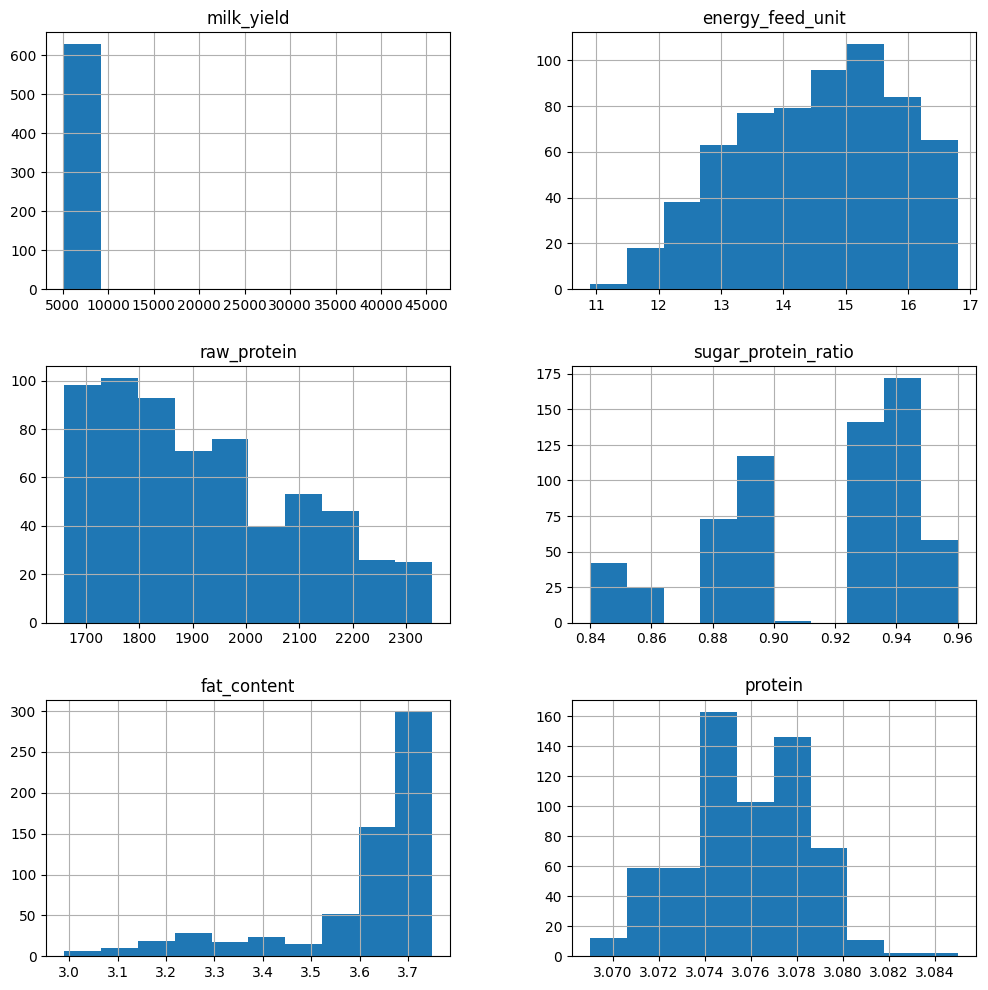

In [24]:
# Построим гистограмму для всех числовых столбцов таблицы на одном графике
ferma_main[['milk_yield','energy_feed_unit','raw_protein','sugar_protein_ratio','fat_content','protein',]].hist(figsize=(12, 12));

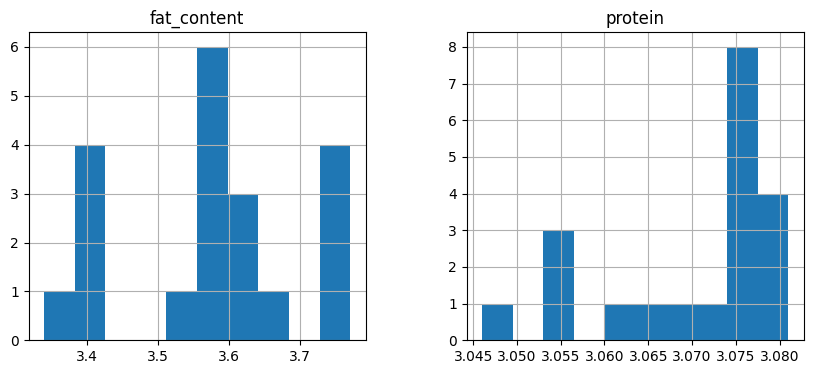

In [25]:
# Построим гистограмму для всех числовых столбцов таблицы на одном графике
cow_buy.hist(figsize=(10, 4));

По результатам анализа сводных данных сложно делать какие-либо выводы. Рассмотрим каждый признак детальнее. 

### Данные о стаде фермера

#### Удой молока

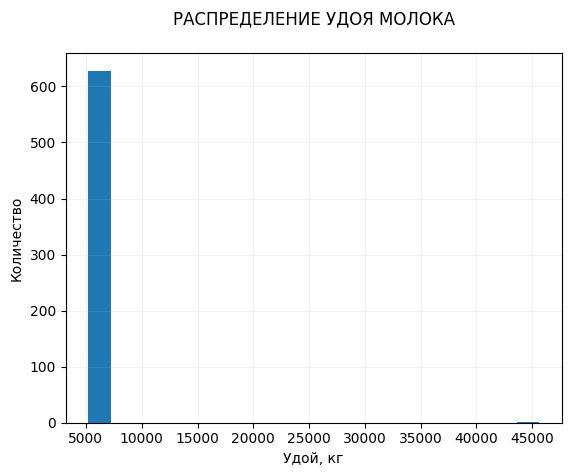

In [26]:
# построим гистограмму
plt.hist(ferma_main['milk_yield'], bins=20)
plt.title('Распределение удоя молока\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Удой, кг')
plt.ylabel('Количество');

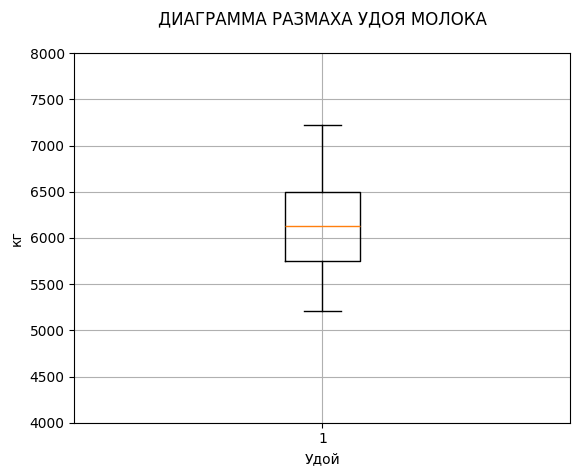

In [27]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['milk_yield'])
plt.title('Диаграмма размаха удоя молока\n'.upper())
plt.grid()
plt.ylim(4000, 8000)
plt.xlabel('Удой')
plt.ylabel('кг');

In [28]:
ferma_main['milk_yield'].describe()

count      629.000000
mean      6188.750397
std       1644.795489
min       5204.000000
25%       5751.000000
50%       6133.000000
75%       6501.000000
max      45616.000000
Name: milk_yield, dtype: float64

In [29]:
# проверим откуда появилось максимальное значение в выборке
ferma_main.sort_values(by='milk_yield', ascending=False).head()

id  milk_yield  energy_feed_unit  raw_protein  sugar_protein_ratio  \
16    17       45616              11.5         1675                 0.93   
70    71        7222              16.8         2157                 0.95   
135  136        7207              16.6         2343                 0.94   
296  297        7201              15.8         2077                 0.94   
294  295        7197              15.6         2241                 0.94   

               breed pasture_type dad_bull_breed  fat_content  protein  \
16    Вис Бик Айдиал    Холмистое         Айдиал         3.22    3.076   
70    Вис Бик Айдиал    Холмистое         Айдиал         3.70    3.076   
135   Вис Бик Айдиал    Холмистое         Айдиал         3.72    3.078   
296  РефлешнСоверинг    Холмистое         Айдиал         3.71    3.072   
294  РефлешнСоверинг    Холмистое         Айдиал         3.71    3.075   

    milk_taste          age  
16      вкусно  более_2_лет  
70      вкусно  более_2_лет  
135     вкусно  более_2_лет  
296     вкусно  более_2_лет  
294     вкусно  более_2_лет

In [30]:
# похоже на ошибку при вводе данных. удалим строку с этим значением
ferma_main.drop(16, inplace=True)

# проверим как изменилось описание данных
ferma_main['milk_yield'].describe()

count     628.000000
mean     6125.968153
std       475.857053
min      5204.000000
25%      5749.750000
50%      6132.500000
75%      6501.000000
max      7222.000000
Name: milk_yield, dtype: float64

В результате анализа значений для столбца "Удой молока" (`milk_yield`) было выявлено значение, выбивающееся из "общей картины". Вероятно была допущена опечатка при вводе данных. 

Т.к. значения в данном столбце важны для задачи исследования, удалим некорректное значение. 

Из описания данных можно сделать вывод, что среднее значение удоя молока почти совпадает с медианным значением. Максимальное значение удоя - 7222 кг, минимальное - 5204, а стандартное отклонение составляет ~475. 

На гистограмме наблюдаем нормальное распределение.

#### Вкус молока

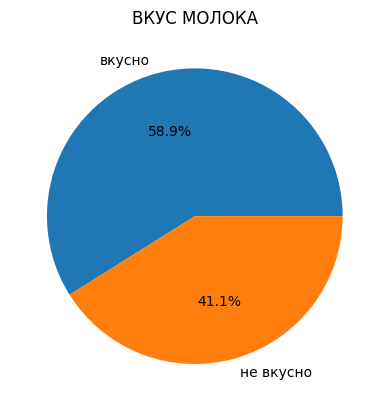

In [31]:
ferma_main.value_counts('milk_taste').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Вкус молока'.upper())
plt.xlabel('')
plt.ylabel('');

Распределение вкусовых характеристик молока составляет почти 60 на 40%. 

#### ЭКЕ (Энергетическая кормовая единица)

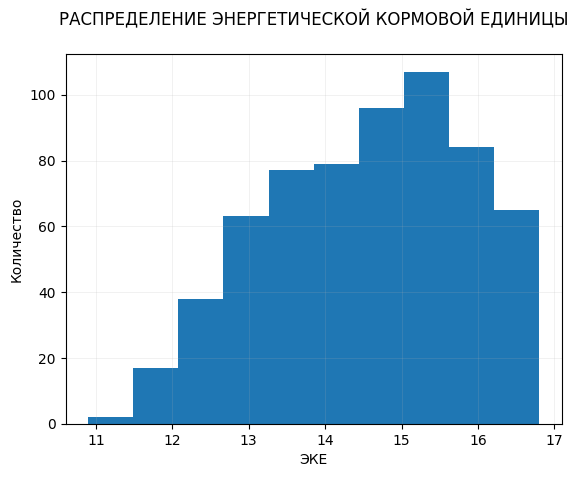

In [32]:
ferma_main['energy_feed_unit'].plot(kind='hist')
plt.title('Распределение энергетической кормовой единицы\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('ЭКЕ')
plt.ylabel('Количество');

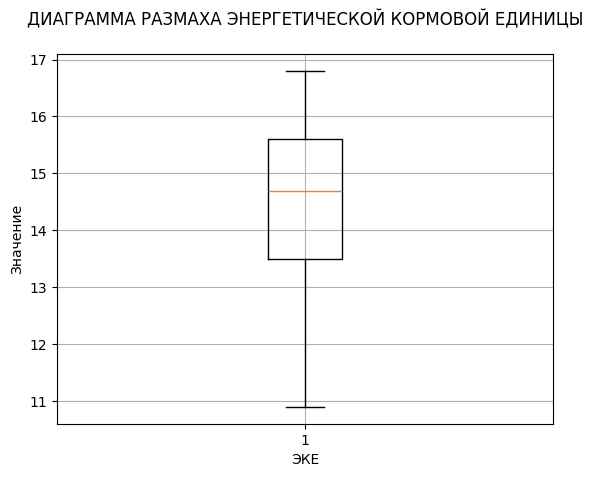

In [33]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['energy_feed_unit'])
plt.title('Диаграмма размаха энергетической кормовой единицы\n'.upper())
plt.grid()
plt.xlabel('ЭКЕ')
plt.ylabel('Значение');

In [34]:
ferma_main['energy_feed_unit'].describe()

count    628.000000
mean      14.548726
std        1.301777
min       10.900000
25%       13.500000
50%       14.700000
75%       15.600000
max       16.800000
Name: energy_feed_unit, dtype: float64

Распределение ЭКЕ похоже на нормальное распределение.

Выбросы в данных отсутствуют. Среднее и медианное значение почти равны, стандартное отклонение ~1.3. 

#### Сырой протеин

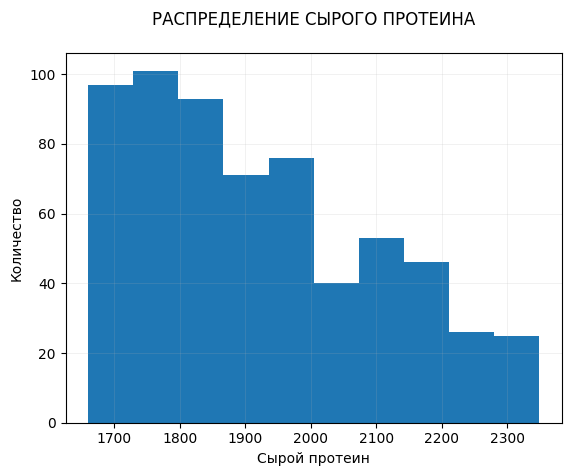

In [35]:
ferma_main['raw_protein'].plot(kind='hist')
plt.title('Распределение сырого протеина\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Сырой протеин')
plt.ylabel('Количество');

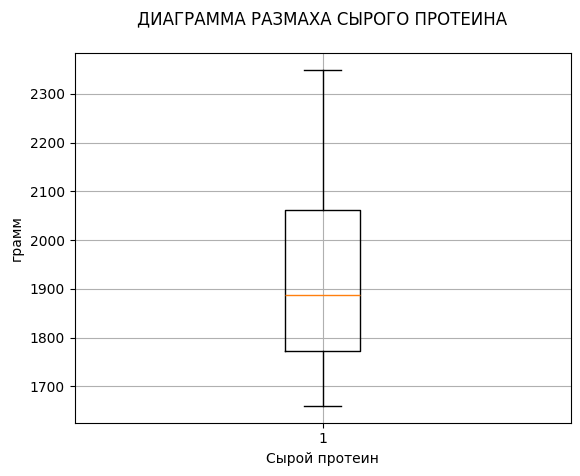

In [36]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['raw_protein'])
plt.title('Диаграмма размаха сырого протеина\n'.upper())
plt.grid()
plt.xlabel('Сырой протеин')
plt.ylabel('грамм');

In [37]:
ferma_main['raw_protein'].describe()

count     628.000000
mean     1923.759554
std       182.832816
min      1660.000000
25%      1771.750000
50%      1888.000000
75%      2062.250000
max      2349.000000
Name: raw_protein, dtype: float64

Выбросы в данных отсутствуют. 

Максимальное значение сырого протеина составляет 2349 г, минимальное - 1660 г. 

Распределение не похоже на нормальное.

#### СПО (Сахаро-протеиновое соотношение)

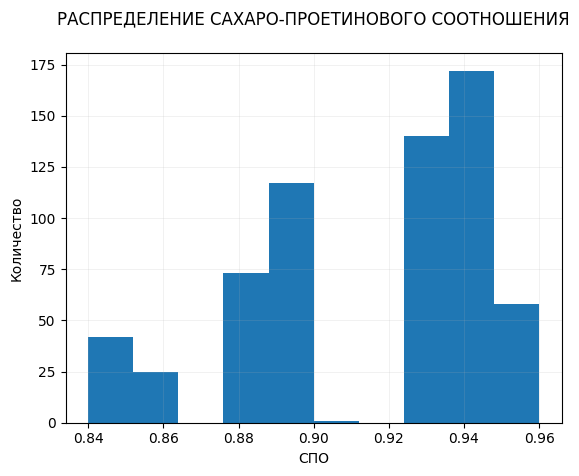

In [38]:
ferma_main['sugar_protein_ratio'].plot(kind='hist')
plt.title('Распределение сахаро-проетинового соотношения\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('СПО')
plt.ylabel('Количество');

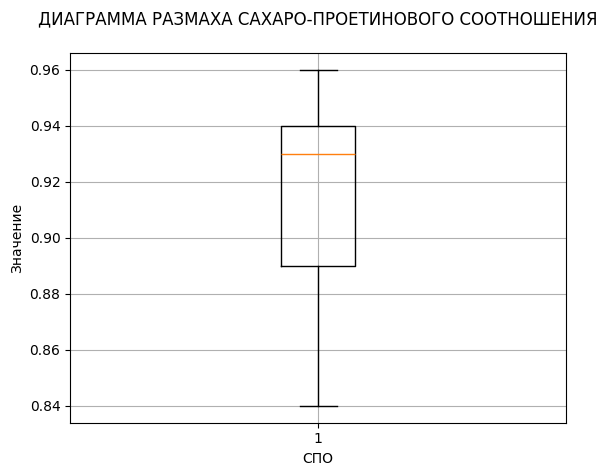

In [39]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['sugar_protein_ratio'])
plt.title('Диаграмма размаха сахаро-проетинового соотношения\n'.upper())
plt.grid()
plt.xlabel('СПО')
plt.ylabel('Значение');

In [40]:
ferma_main['sugar_protein_ratio'].describe()

count    628.000000
mean       0.913089
std        0.032221
min        0.840000
25%        0.890000
50%        0.930000
75%        0.940000
max        0.960000
Name: sugar_protein_ratio, dtype: float64

Отношение сахара к протеину в корме коров распределено неравномерно. 

Значение распределены от 0.84 до 0.96. ~Учитывая характер распределения протеина можно сделать вывод, что именно количество сахара в корме распределяется неравномерно.~ 

Выбросы в данных отсутствуют.

Распределение не похоже на нормальное.

#### Порода коровы

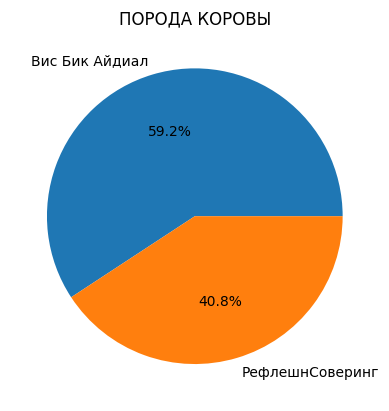

In [41]:
ferma_main.value_counts('breed').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Порода коровы'.upper())
plt.xlabel('')
plt.ylabel('');

Распределение количества коров разных пород составляет почти 60 на 40% (похоже на распределение для вкуса молока).

#### Тип пастбища

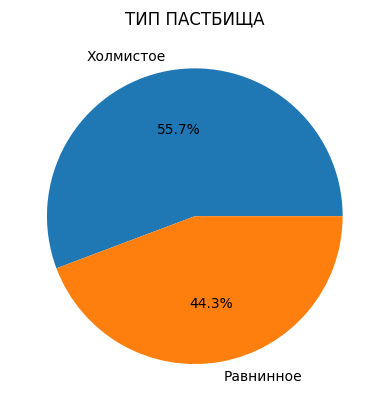

In [42]:
ferma_main.value_counts('pasture_type').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Тип пастбища'.upper())
plt.xlabel('')
plt.ylabel('');

В выборке представлено два типа пастбищ. Распределение пастбищ составляет 55 на 45%.

#### Порода папы-быка

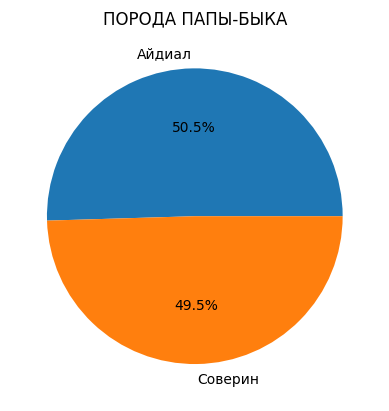

In [43]:
ferma_main.value_counts('dad_bull_breed').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Порода папы-быка'.upper())
plt.xlabel('')
plt.ylabel('');

В выборке представлены две породы быков. Их соотношение составляет 50 на 50%. 

#### Жирность

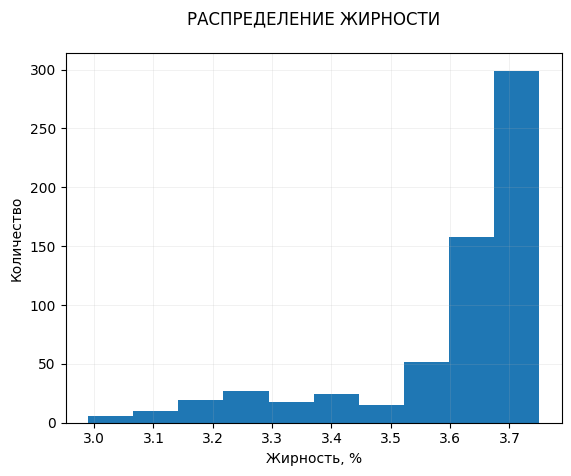

In [44]:
ferma_main['fat_content'].plot(kind='hist')
plt.title('Распределение жирности\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Жирность, %')
plt.ylabel('Количество');

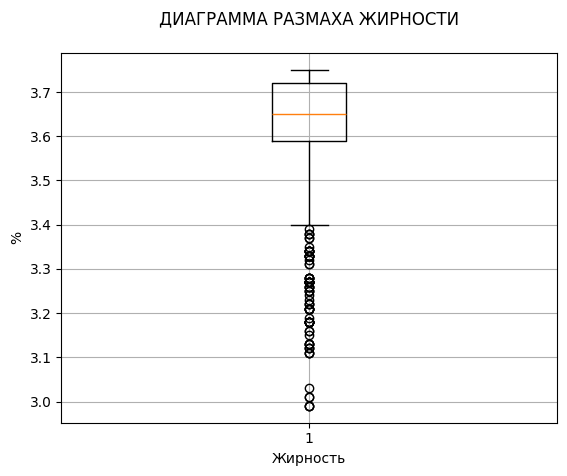

In [45]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['fat_content'])
plt.title('Диаграмма размаха жирности\n'.upper())
plt.grid()
plt.xlabel('Жирность')
plt.ylabel('%');

In [46]:
ferma_main['fat_content'].describe()

count    628.000000
mean       3.604268
std        0.168093
min        2.990000
25%        3.590000
50%        3.650000
75%        3.720000
max        3.750000
Name: fat_content, dtype: float64

Статистическое описание данных говорит о том, что в выборке по жирности молока присутствуют выбросы (на значениях ниже 3.4%).

Но такие данные допустимы для параметра жирности молока. 

Распределение не похоже на нормальное.

#### Белок

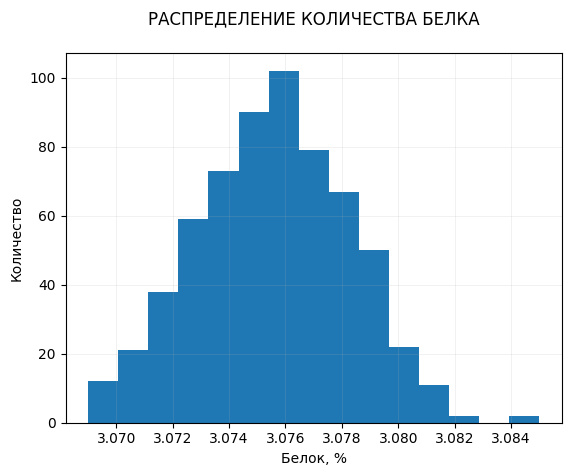

In [47]:
plt.hist(ferma_main['protein'], bins=15)
plt.title('Распределение количества белка\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Белок, %')
plt.ylabel('Количество');

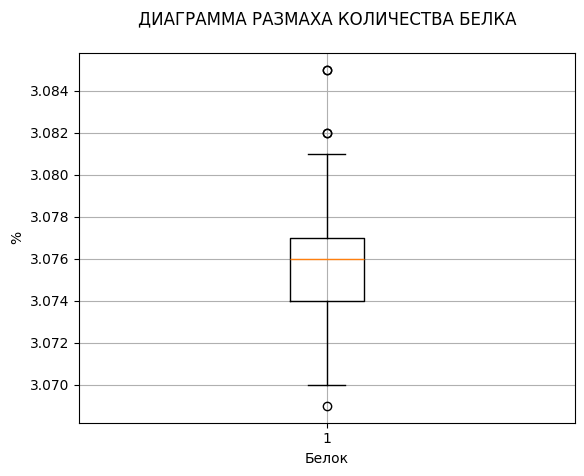

In [48]:
# построим диаграмму разамаха
plt.boxplot(ferma_main['protein'])
plt.title('Диаграмма размаха количества белка\n'.upper())
plt.grid()
plt.xlabel('Белок')
plt.ylabel('%');

In [49]:
ferma_main['protein'].describe()

count    628.000000
mean       3.075670
std        0.002551
min        3.069000
25%        3.074000
50%        3.076000
75%        3.077000
max        3.085000
Name: protein, dtype: float64

In [50]:
# удалим выбросы
ferma_main = ferma_main[ferma_main['protein'] < 3.081]
ferma_main = ferma_main[ferma_main['protein'] >= 3.07]

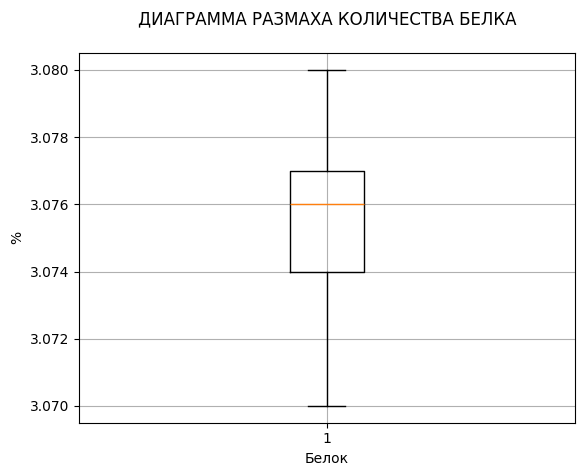

In [51]:
# проверим, что данные изменились корректно
plt.boxplot(ferma_main['protein'])
plt.title('Диаграмма размаха количества белка\n'.upper())
plt.grid()
plt.xlabel('Белок')
plt.ylabel('%');

Для белка характерно нормальное распределение. 

В соответствии с диаграммой размаха наблюдаются выбросы как снизу, так и сверху от медианы. Удалили выбросы, чтобы они не влияли на качество модели. 

#### Возраст

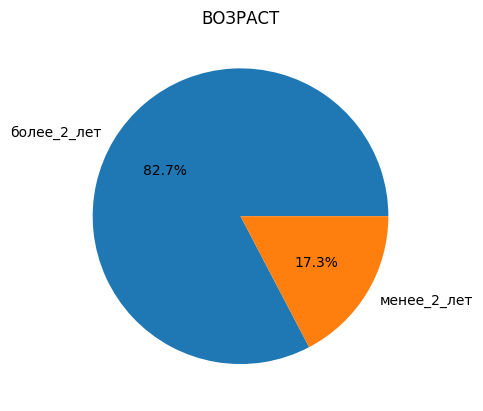

In [52]:
ferma_main.value_counts('age').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Возраст'.upper())
plt.xlabel('')
plt.ylabel('');

В соотвествии с выборкой в основном представлены коровы возрастом более 2 лет. Соотношение составляет 82,5 на 17.5%. 

**Вывод**

По результатам исследовательского анализа данных можно сделать следующие выводы: 
- выявлены параметры, имеющие нормальное распределение: `milk_yield`, `energy_feed_unit`, `protein`;
- количественные признаки, для которых распределение не похоже на нормальное: `raw_protein`, `sugar_protein_ratio`, `fat_content`.
- распределение большинства категориальных признаков приближается к 50 на 50% (вкус молока, порода коровы, тип пастбища, порода папы-быка);
- чаще встречаются коровы старше 2 лет (~83% от общего числа коров).

Что касается качества данных: 
- отмечен выброс в данных столбца Удой. Т.к. значения в данном столбце напрямую влияют на результаты исследования, некорректное значение было удалено;
- выявлены выбросы в столбце Белок. Строки с выбросами удалены; 
- в иных данных выбросов не обнаружено. 

### Данные о коровах «ЭкоФермы»

#### Порода коровы

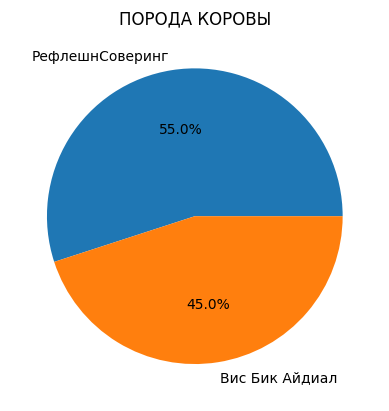

In [53]:
cow_buy.value_counts('breed').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Порода коровы'.upper())
plt.xlabel('')
plt.ylabel('');

В выборке представлено две породы. Распределение составляет 50 на 50%.

#### Тип пастбища

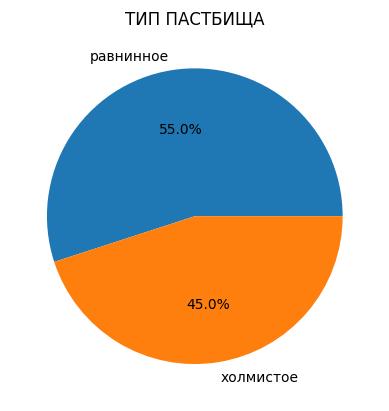

In [54]:
cow_buy.value_counts('pasture_type').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Тип пастбища'.upper())
plt.xlabel('')
plt.ylabel('');

In [55]:
# приведем значения к формату "с заглавной буквы"
cow_buy['pasture_type'] = cow_buy['pasture_type'].str.title()

В выборке представлено два типа пастбищ. Распределение составляет 50 на 50%.

Привели значения в столбце к значениям с заглавной буквы. 

#### Порода папы-быка

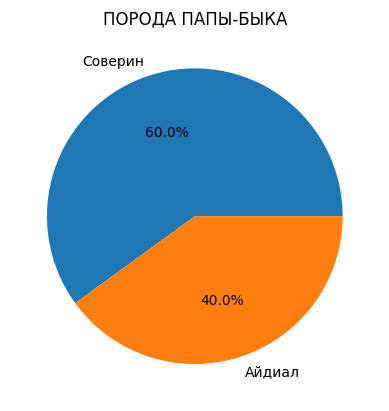

In [56]:
cow_buy.value_counts('dad_bull_breed').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Порода папы-быка'.upper())
plt.xlabel('')
plt.ylabel('');

В выборке представлено две породы. Распределение составляет 62.5 на 37.5%.

#### Имя папы-быка

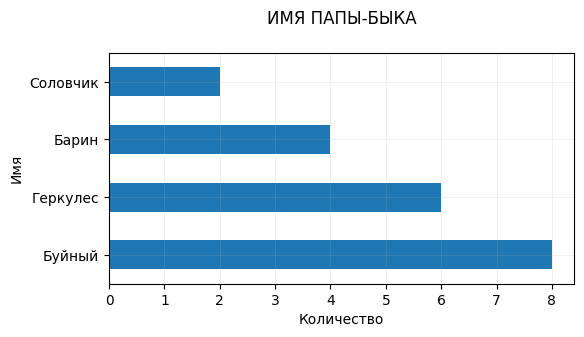

In [57]:
cow_buy.value_counts('dad_bull_name').plot(kind='barh', figsize=(6, 3))
plt.title('Имя папы-быка\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Количество')
plt.ylabel('Имя');

В выборке представлено 4 папы-быка. Наиболее *плодовитый* - Буйный. 

#### Текущая жирность

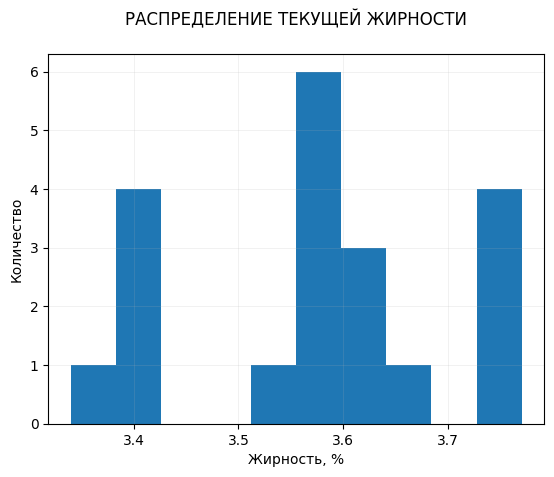

In [58]:
cow_buy['fat_content'].plot(kind='hist')
plt.title('Распределение текущей жирности\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Жирность, %')
plt.ylabel('Количество');

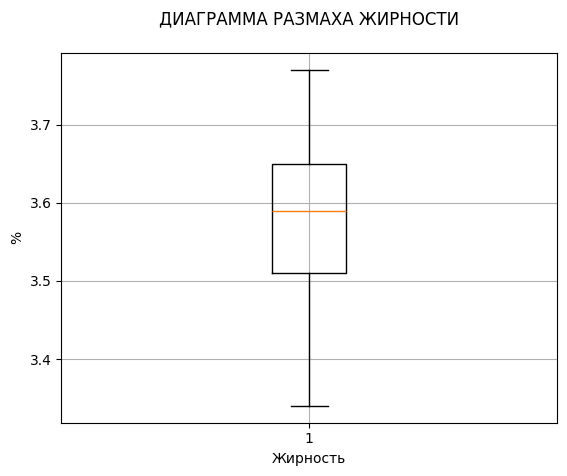

In [59]:
# построим диаграмму разамаха
plt.boxplot(cow_buy['fat_content'])
plt.title('Диаграмма размаха жирности\n'.upper())
plt.grid()
plt.xlabel('Жирность')
plt.ylabel('%');

In [60]:
cow_buy['fat_content'].describe()

count    20.000000
mean      3.577500
std       0.126818
min       3.340000
25%       3.510000
50%       3.590000
75%       3.650000
max       3.770000
Name: fat_content, dtype: float64

Выбросы в выборке отсутствуют. 

Медианное и среднее значения практически совпадают и равны 3.5%. 

Распределение не похоже на нормальное.

#### Текущий уровень белка

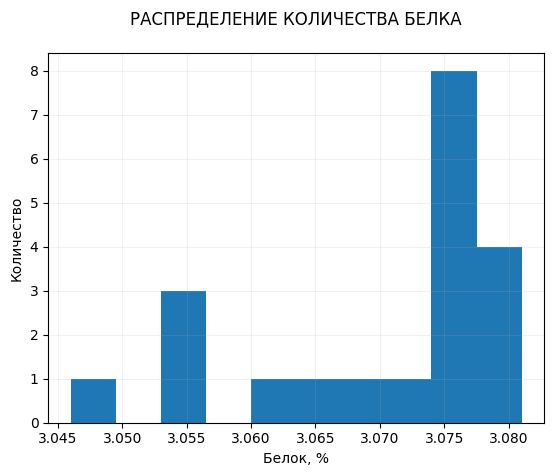

In [61]:
cow_buy['protein'].plot(kind='hist')
plt.title('Распределение количества белка\n'.upper())
plt.grid(linewidth=0.4, alpha=0.3)
plt.xlabel('Белок, %')
plt.ylabel('Количество');

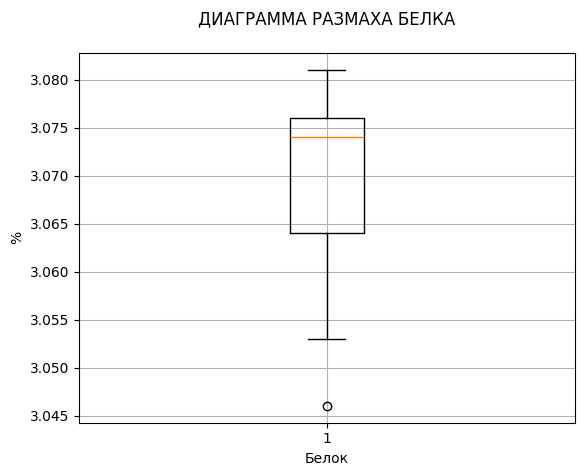

In [62]:
# построим диаграмму разамаха
plt.boxplot(cow_buy['protein'])
plt.title('Диаграмма размаха белка\n'.upper())
plt.grid()
plt.xlabel('Белок')
plt.ylabel('%');

In [63]:
cow_buy['protein'].describe()

count    20.000000
mean      3.069500
std       0.010339
min       3.046000
25%       3.064000
50%       3.074000
75%       3.076000
max       3.081000
Name: protein, dtype: float64

Выбросы в данных отсутствуют. 

Очень низкой значение стандартного отклонения - 0.011. Медианное и среднее значения практически совпадают. 

Максимальное значение составляет 3.08, минимальное - 3.04. 

Распределение не похоже на нормальное.

#### Возраст

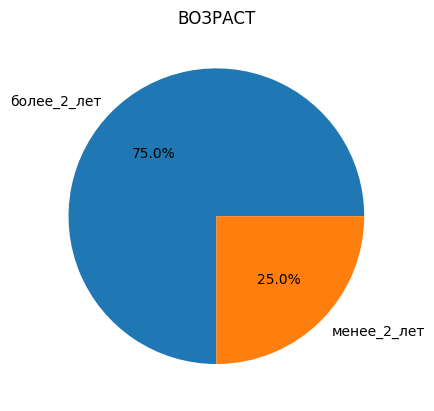

In [64]:
cow_buy.value_counts('age').plot(kind='pie', subplots=True, autopct='%1.1f%%')
plt.title('Возраст'.upper())
plt.xlabel('')
plt.ylabel('');

В соотвествии с выборкой в основном представлены коровы возрастом более 2 лет. Соотношение составляет 68.8 на 31.2%. 

**Вывод**

Данные от "ЭкоФермы" в основном представлены категориальными признаками. Распределение большинства категориальных признаков приближается к 50 на 50%.

Чаще встречаются коровы старше 2 лет (~69% от общего числа коров).

Выбросы в данных не обнаружены. 

Представленные количественные признаки распределены не нормально.

Для расчета значений Удой не подойдут признаки текущая жирность и текущий уровень белка. 

**Вывод по результатам исследовательского анализа данных**

По результатам исследовательского анализа данных можно сделать следующие выводы: 
- выявлены параметры, имеющие нормальное распределение: `milk_yield`, `energy_feed_unit`, `protein`. 
- количественные признаки, которые распределены не нормально: `raw_protein`, `sugar_protein_ratio`, `fat_content`;
- распределение большинства категориальных признаков приближается к 50 на 50% (вкус молока, порода коровы, тип пастбища, порода папы-быка);
- в выборках у фермера и "ЭкоФермы" чаще встречаются коровы старше 2 лет (примерно 70-80% от общего числа коров).

Что касается качества данных: 
- отмечен выброс в данных столбца Удой. Т.к. значения в данном столбце напрямую влияют на результаты исследования, некорректное значение было удалено;
- выявлены выбросы в столбце Белок, удалены; 
- в иных данных выбросов не обнаружено. 

Т.к. размерность в параметрах отличается между собой (например, удой представлен в кг, сырой протеин в г, жирность и белов в % и т.п.) на этапе разработке модели потребуется масштабировать данные. 

В выборках представлены некоторые категориальные признаки и до обучения модели потребуется их кодировать. 

## Корреляционный анализ

### Коэффициенты корреляции

<Axes: >

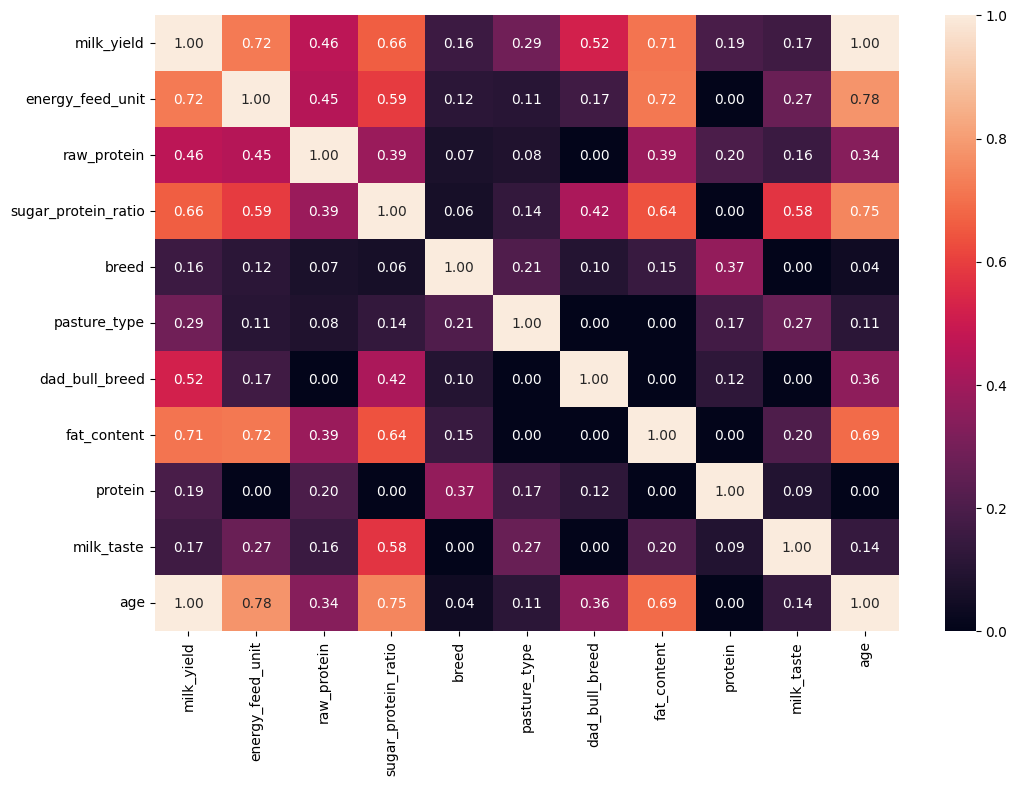

In [65]:
# посмотрим на коэффициент корреляции между признаками, используя коэффициент Phik
# df_corr = ferma_main[['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'fat_content', 'protein']]

df_corr = ferma_main[['milk_yield', 'energy_feed_unit', 'raw_protein', 'sugar_protein_ratio', 'breed', 'pasture_type', 'dad_bull_breed', 'fat_content',  'protein', 'milk_taste', 'age', ]]
plt.figure(figsize=(12, 8))


interval_cols=['milk_yield', 'energy_feed_unit', 'protein', 'raw_protein', 'sugar_protein_ratio', 'fat_content']
sns.heatmap(df_corr.phik_matrix(interval_cols=interval_cols), annot=True, fmt='.2f')

По результатам анализа тепловой диаграммы выявлено:

1. Для параметра Удой (`milk_yield`):
- высокая теснота связи с параметром ЭКЕ (`energy_feed_unit`) - 0.72
- умеренная теснота связи с параметром Сырой протеин (`raw_protein`) - 0.46
- высокая теснота связи с параметром СПО (`sugar_protein_ratio`) - 0.66
- заметная теснота связи с параметром Жирность (`fat_content`) - 0.6
- слабая теснота связи с параметром Порода (`breed`) - 0.16
- умеренная теснота связи с параметром Тип пастбища (`pasture_type`) - 0.29
- умеренная теснота связи с параметром Порода папы-быка (`dad_bull_breed`) - 0.52
- высокая теснота связи с параметром Жирность (`fat_content`) - 0.71
- слабая теснота связи с параметром Белок (`protein`) - 0.19
- слабая теснота связи с параметром Вкус молока (`milk_taste`) - 0.17
- линейная зависимость с параметром Возраст (`age`) - 1.

2. Высокие уровни корреляции (выше 0.7) выявлены:
- параметр ЭКЕ (`energy_feed_unit`) и параметр Возраст (`age`) - 0.78
- параметр СПО (`sugar_protein_ratio`) и параметр Возраст (`age`) - 0.75
- параметр ЭКЕ (`energy_feed_unit`) и параметр Жирность (`fat_content`) - 0.7

### Диаграммы рассеяния

In [66]:
# создадим отдельный список с категориальными признаками
ferma_categories = ['breed', 'pasture_type', 'dad_bull_breed', 'milk_taste', 'age']

# создадим функцию для создания графиков
def make_scatterplot(df, parameter_1, parameter_2 , category, xlabel, ylabel):
    graph = sns.scatterplot(data=df, x=parameter_1, y=parameter_2, hue=category)
    graph.legend()
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);

#### Удой и ЭКЕ

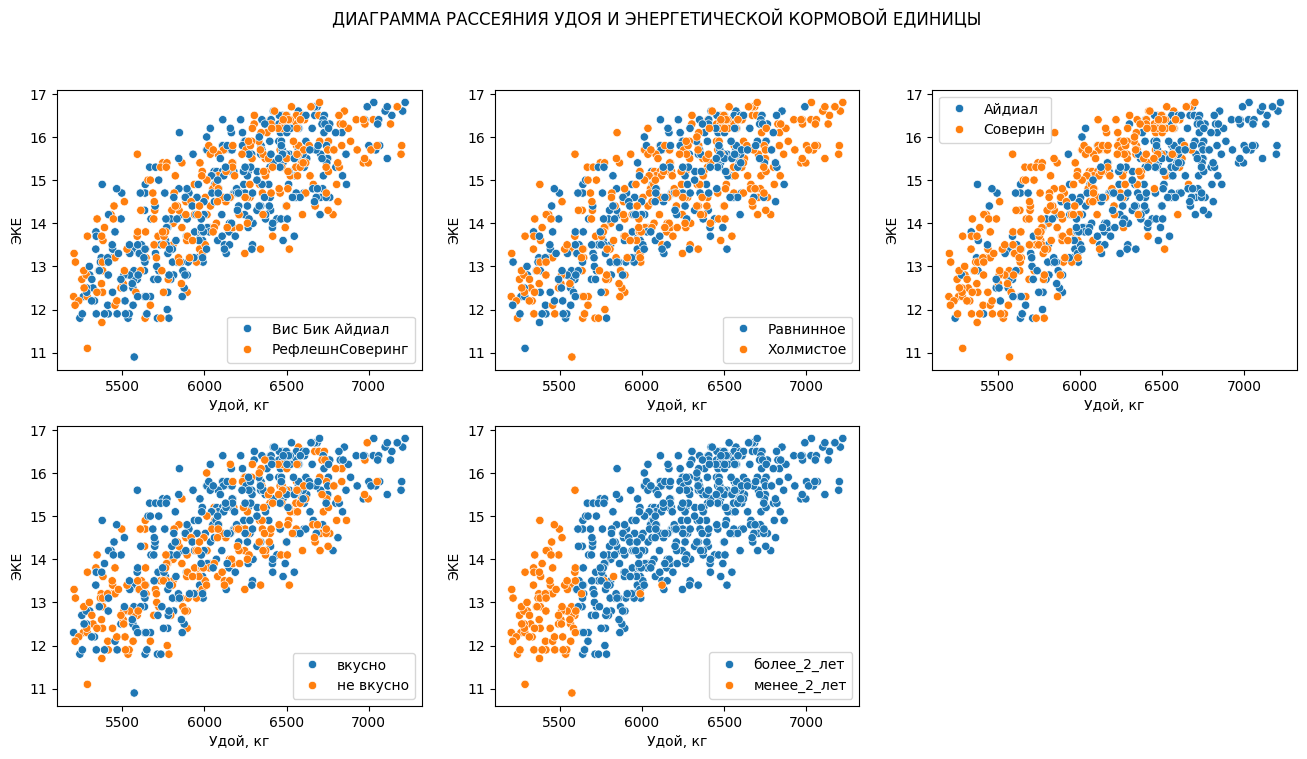

In [67]:
# построим диаграмму
plt.figure(figsize=(16, 8))
plt.axis('off')
plt.suptitle('Диаграмма рассеяния удоя и энергетической кормовой единицы\n'.upper());

i = 1
for category in ferma_categories:
    plt.subplot(2, 3, i)
    make_scatterplot(ferma_main, 'milk_yield', 'energy_feed_unit', category, 'Удой, кг', 'ЭКЕ')
    i+=1

Подтверждается зависимость между параметрами удоя и ЭКЕ. Нелинейная зависимость.

Порода коровы не влияет на параметры Удой и ЭКЕ. 

Для коров старше 2 лет значения удоя и ЭКЕ выше, чем для молодых коров. 

Значения удоя для коров, пасущихся на холмистых пастбищах, выше, чем для коров с равнинных пастбищ. 

Для породы папы-быка Айдиал значения удоя выше, чем для породы Соверин. 

Удой вкусного молока, немного выше, чем не вкусного.

Тип пастбища, порода папы-быка, вкус молока не влияют на параметр ЭКЕ.

#### Удой и Сырой протеин

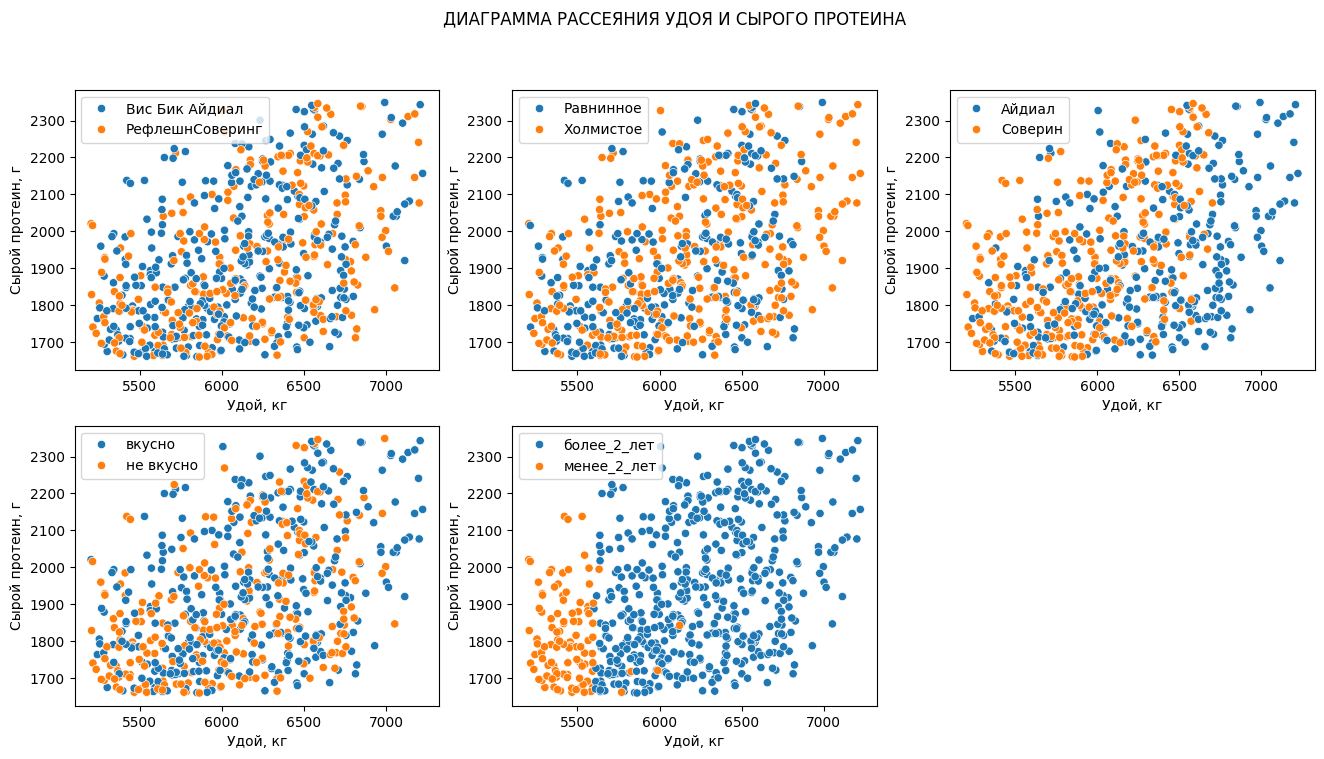

In [68]:
# построим диаграмму
plt.figure(figsize=(16, 8))
plt.suptitle('Диаграмма рассеяния удоя и сырого протеина\n'.upper())
plt.axis('off')

i = 1
for category in ferma_categories:
    plt.subplot(2, 3, i)
    make_scatterplot(ferma_main, 'milk_yield', 'raw_protein', category, 'Удой, кг', 'Сырой протеин, г')
    i+=1

Подтверждается слабая корреляция между параметрами Удой и Сырой протеин. Похоже на линейную зависимость.

Порода коровы, тип пастбища, порода папы-быка, вкус молока не влияют на параметр Сырой протеин. 

У молодых коров  содержание сырого протеина в корме выше, чем у коров старше 2 лет.  

#### Удой и СПО

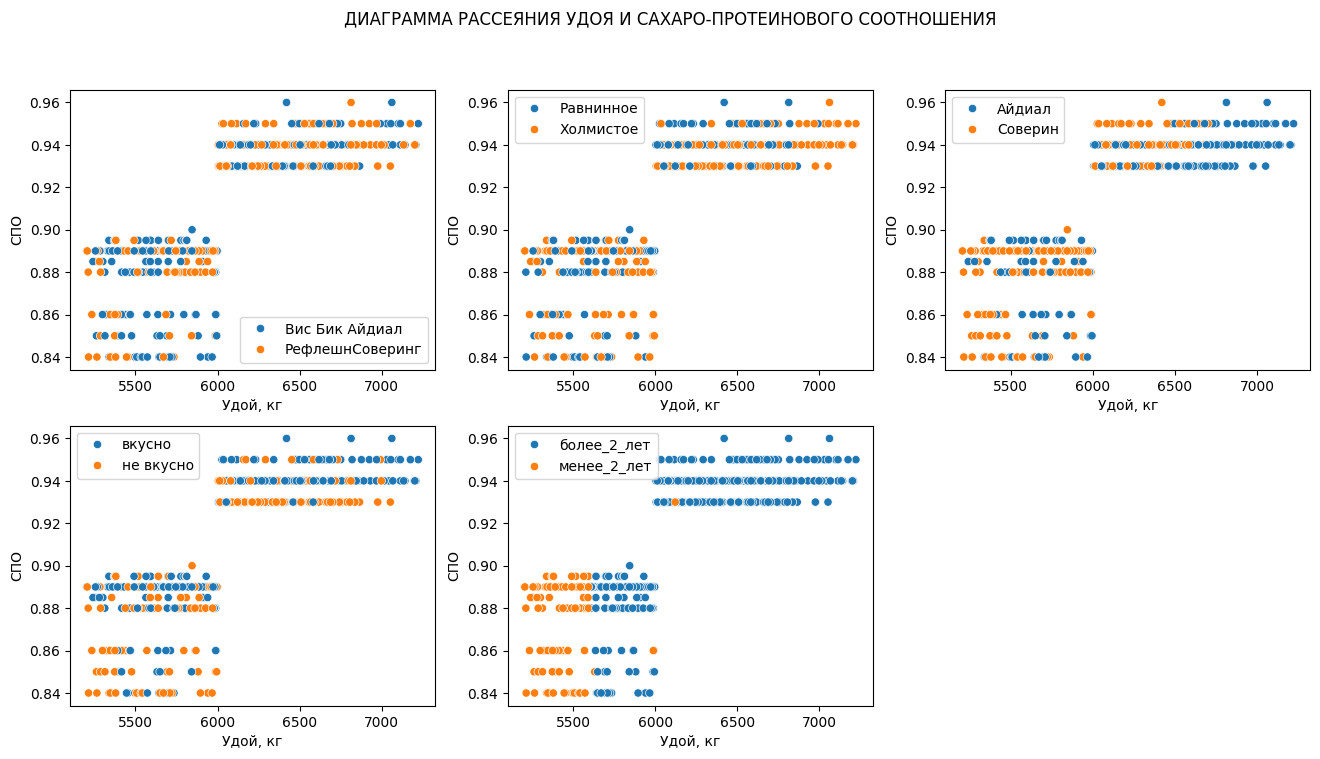

In [69]:
# построим диаграмму
plt.figure(figsize=(16, 8))
plt.suptitle('Диаграмма рассеяния удоя и сахаро-протеинового соотношения\n'.upper())
plt.axis('off')

i = 1
for category in ferma_categories:
    plt.subplot(2, 3, i)
    make_scatterplot(ferma_main, 'milk_yield', 'sugar_protein_ratio', category, 'Удой, кг', 'СПО')
    i+=1

Подтверждается высокая корреляция между удоем и СПО. Нелинейная зависимость. На диаграмме рассеяния наблюдения сгруппированы в два кластера.

Порода коровы, тип пастбища, порода папы-быка, вкус молока не влияют на параметр СПО. 

Отношение сахара к протеину в корме молодых коров ниже, чем у коров старше 2 лет. 


#### Удой и Жирность

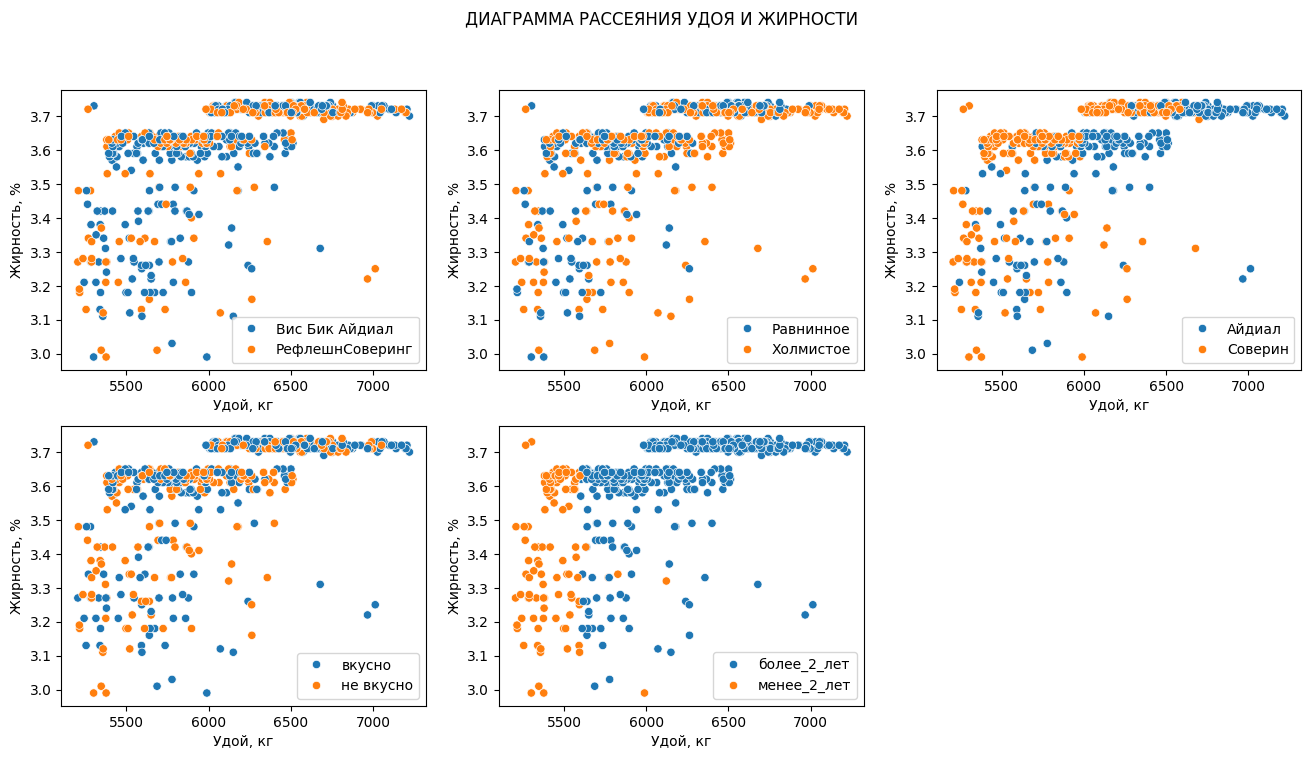

In [70]:
# построим диаграмму
plt.figure(figsize=(16, 8))
plt.suptitle('Диаграмма рассеяния удоя и жирности\n'.upper())
plt.axis('off')

i = 1
for category in ferma_categories:
    plt.subplot(2, 3, i)
    make_scatterplot(ferma_main, 'milk_yield', 'fat_content', category, 'Удой, кг', 'Жирность, %')
    i+=1

Подтверждается наличие корреляции между удоем и жирностью молока. Нелинейная зависимость.

Ни один из представленных категориальных параметров не влияет на параметр Жирность. 

#### Удой и Белок

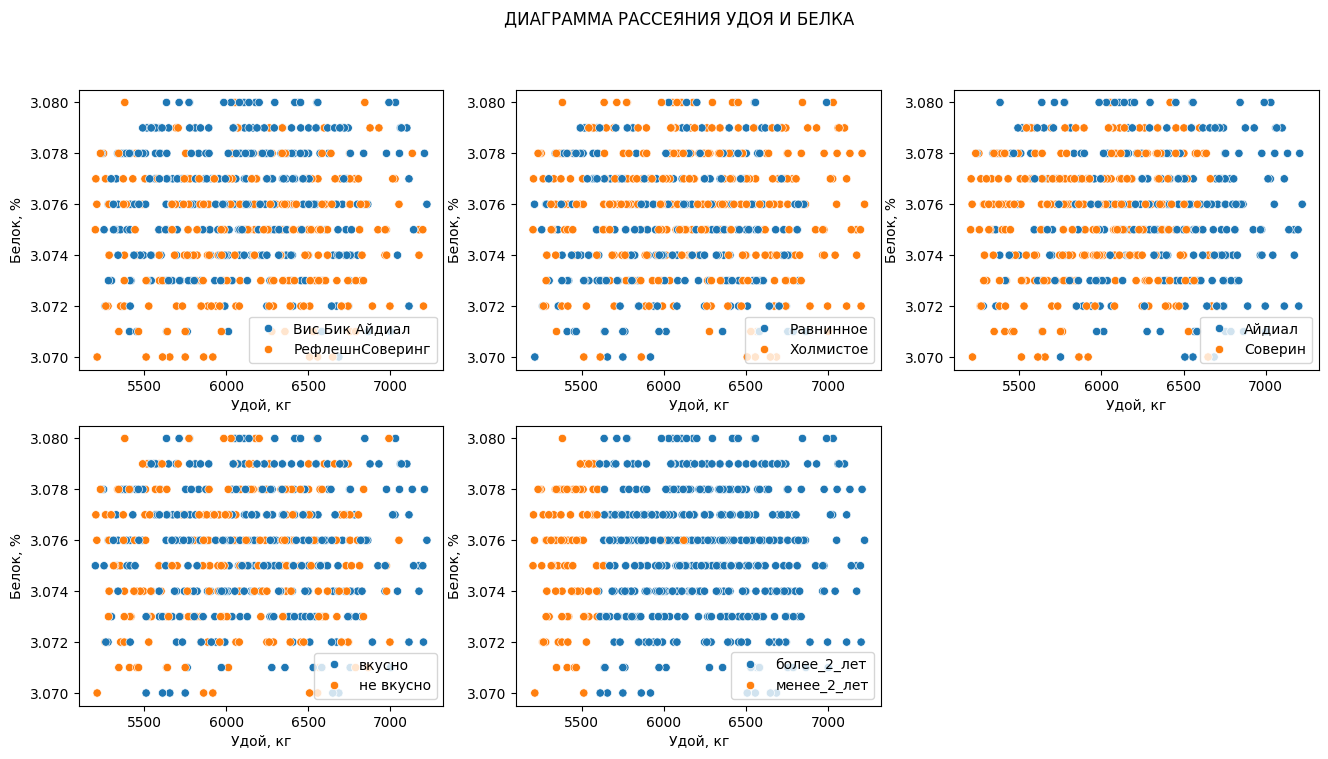

In [71]:
# построим диаграмму
plt.figure(figsize=(16, 8))
plt.suptitle('Диаграмма рассеяния удоя и белка\n'.upper())
plt.axis('off')

i = 1
for category in ferma_categories:
    plt.subplot(2, 3, i)
    make_scatterplot(ferma_main, 'milk_yield', 'protein', category, 'Удой, кг', 'Белок, %')
    i+=1

Подтверждается отсутствие корреляции между удоем и белком. 

Ни один из представленных категориальных параметров кроме породы коровы не влияет на параметр Белок. 

Для породы Вис Бик Айдиал содержание белка в молоке немного выше, чем для породы РефлешнСоверинг. 

**Вывод по результатам корреляционного анализа данных**

Наблюдается линейная зависимость между параметром Удой и Сырой протеин.  

Наблюдается зависимость между возрастом коровы и параметрами Удой, ЭКЕ, Сырой протеин, СПО.

Нелинейная связь выявлена между параметром Удой и параметрами СПО, ЭКЕ, Жирность. 

Для работы с признаком СПО потребуетя преобразовать СПО в категоральный бинарный признак, выбрав значение, которое будет разделять границу между кластерами. 

Для работы с признаком ЭКЕ потребуется исключить нелинейность между ними путем введения нового признака ЭКЕ в квадрате. 

Мультиколлинеарные признаки отсутствуют (коэффициент корреляции наиболее близкий между параметрами ЭКЕ и СПО - 0.75).

## №1. Обучение модели линейной регрессии

### Подготовка данных

**Целевой признак: Удой**

Для обучения модели линейной регрессии будем использовать признаки:
1. Количественные:
- ЭКЕ `energy_feed_unit`
- Сырой протеин `raw_protein`
2. Категориальные:
- Порода `breed`
- Тип пастбища `pasture_type`
- Порода папы-быка `dad_bull_breed`
- Возраст коровы `age`

Параметр СПО не используем для обучения, так как выявлена нелинейная зависимость с параметром Удой. 

Параметр жирность и вкус молока не используем для обучения, так как это характеристики полученного молока, т.е. параметр не может влиять на удой. 

In [72]:
ferma_main_1 = ferma_main[['milk_yield', 'energy_feed_unit', 'raw_protein', 'breed', 'pasture_type', 'dad_bull_breed', 'age']].copy()
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age']
count_col_names = ['energy_feed_unit', 'raw_protein']

# сохранение входных признаков в переменную X
X = ferma_main_1.drop('milk_yield', axis=1)

# сохранение целевого признака в переменную y
y = ferma_main_1['milk_yield']

# создание константы RANDOM_STATE
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

# вывод необходимых размерностей
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(459, 6)
(153, 6)
(459,)
(153,)


In [73]:
# выбор способа кодирования
try: 
    encoder = OneHotEncoder(drop='first', sparse=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 
 
# кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# посмотрим список новых столбцов
try: 
    encoder_col_names = encoder.get_feature_names() 
except:
    encoder_col_names = encoder.get_feature_names_out() 
    
encoder_col_names

array(['breed_РефлешнСоверинг', 'pasture_type_Холмистое',
       'dad_bull_breed_Соверин', 'age_менее_2_лет'], dtype=object)

In [74]:
# выбор способа масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[count_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[count_col_names]) 

In [75]:
# объединение массивов
X_train = np.hstack([X_train_ohe, X_train_scaled])
X_test = np.hstack([X_test_ohe, X_test_scaled])

### Обучение модели

In [76]:
model_lr = LinearRegression() 

model_lr.fit(X_train, y_train) 

predictions = model_lr.predict(X_test) 

### Оценка работы модели

In [77]:
# посчитаем показатель R²
r2 = r2_score(y_test, predictions)  
all_r2 = {'1': r2}
r2

0.749924766993699

### Анализ остатков

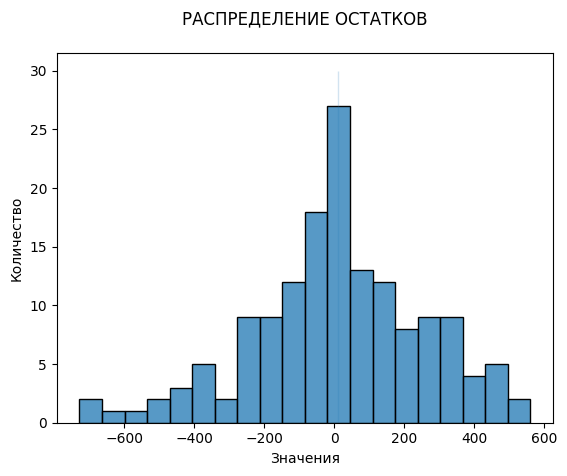

In [78]:
# построим гистограмму распределения остатков
residuals_1 = y_test - predictions
sns.histplot(residuals_1, bins=20)
sns.lineplot(x = residuals_1.median(), y=[0, 30])
plt.title('Распределение остатков\n'.upper())
plt.xlabel('Значения')
plt.ylabel('Количество');

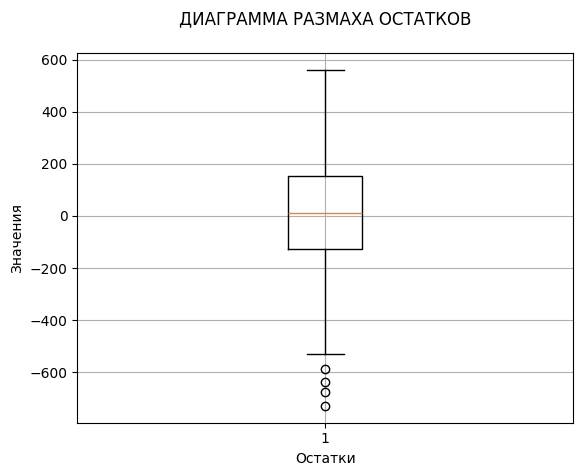

In [79]:
# построим диаграмму разамаха
plt.boxplot(residuals_1)
plt.title('Диаграмма размаха остатков\n'.upper())
plt.grid()
plt.xlabel('Остатки')
plt.ylabel('Значения');

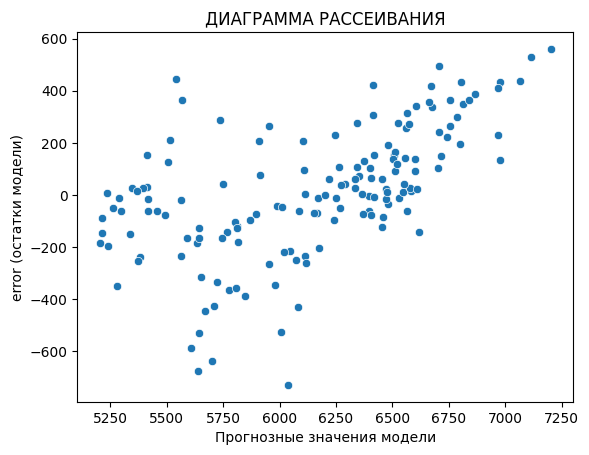

In [80]:
# построим диаграмму рассеивания остатков
graph = sns.scatterplot(x=y_test, y=residuals_1)
plt.title('Диаграмма рассеивания'.upper())
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error (остатки модели)');

### Оценка качества модели

In [81]:
mae = mean_absolute_error(y_test, predictions) 
try:
    rmse = mean_squared_error(y_test, predictions, squared=False) 
except:
    rmse = root_mean_squared_error(y_test, predictions)
    
mse = mean_squared_error(y_test, predictions)

all_mae = {'model_1': mae}
all_rmse = {'model_1': rmse}
all_mse = {'model_1': mse}

**Вывод**

Мы получили значение коэффициента детерминации = 0.7499.

На диаграмме рассеивания остатков видим отклонения от главной диагонали графика - значит модель не объясняет все данные. Предположительно это связано с тем, что для обучения модели использовались нелинейные признаки, и линейная модель не учитывала этого. 

Анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания не похоже на линейное). 

## №2. Обучение модели линейной регрессии

### Подготовка данных

**Целевой признак: Удой**

Для обучения модели линейной регрессии будем использовать признаки:
1. Количественные:
- ЭКЕ `energy_feed_unit` (после подготовки)
- Сырой протеин `raw_protein`
2. Категориальные:
- Порода `breed`
- Тип пастбища `pasture_type`
- Порода папы-быка `dad_bull_breed`
- Возраст коровы `age`
- СПО `sugar_protein_ratio` (после подготовки)

Параметр жирность и вкус молока не используем для обучения, так как это характеристики полученного молока, т.е. параметр не может влиять на удой. 

#### ЭКЕ в квадрате

In [82]:
ferma_main_2 = ferma_main.copy()

In [83]:
# введем новый параметр - ЭКЕ в квадрате
ferma_main_2['EFU_squared'] = ferma_main_2['energy_feed_unit'] ** 2

# проверим, что изменения внесены корректно
ferma_main_2.head()

id  milk_yield  energy_feed_unit  raw_protein  sugar_protein_ratio  \
0   1        5863              14.2         1743                0.890   
1   2        5529              12.8         2138                0.890   
2   3        5810              14.0         1854                0.885   
3   4        5895              12.4         2012                0.885   
4   5        5302              12.8         1675                0.885   

             breed pasture_type dad_bull_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное         Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинное        Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое        Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое         Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинное        Соверин         3.73    3.073   

  milk_taste          age  EFU_squared  
0     вкусно  более_2_лет       201.64  
1     вкусно  менее_2_лет       163.84  
2  не вкусно  более_2_лет       196.00  
3  не вкусно  более_2_лет       153.76  
4     вкусно  менее_2_лет       163.84

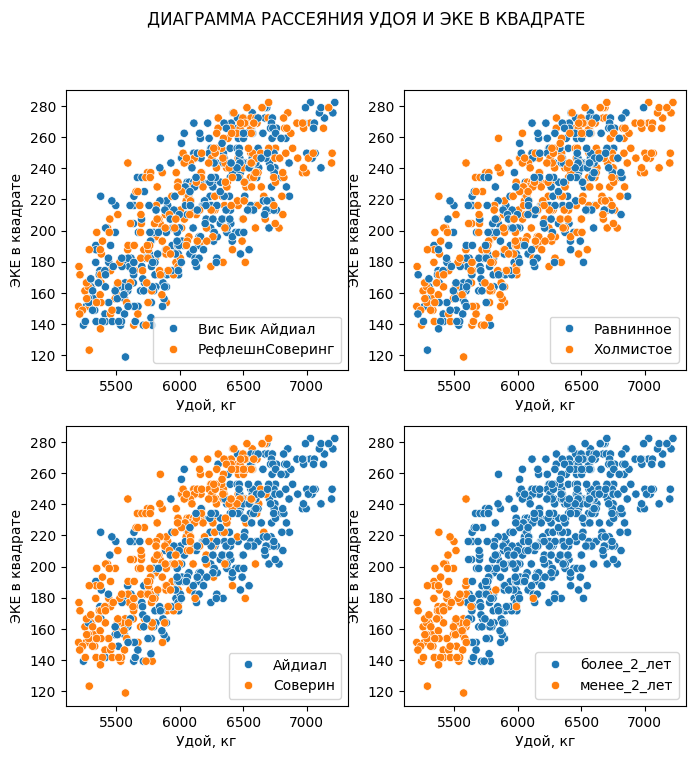

In [84]:
# построим диаграмму
plt.figure(figsize=(8, 8))
plt.suptitle('Диаграмма рассеяния удоя и ЭКЕ в квадрате\n'.upper())
plt.axis('off')

i=1
for category in cat_col_names:
    plt.subplot(2, 2, i)
    graph = sns.scatterplot(data=ferma_main_2, x='milk_yield', y='EFU_squared', hue=category);
    i+=1
    graph.legend()
    plt.xlabel('Удой, кг')
    plt.ylabel('ЭКЕ в квадрате');

#### СПО

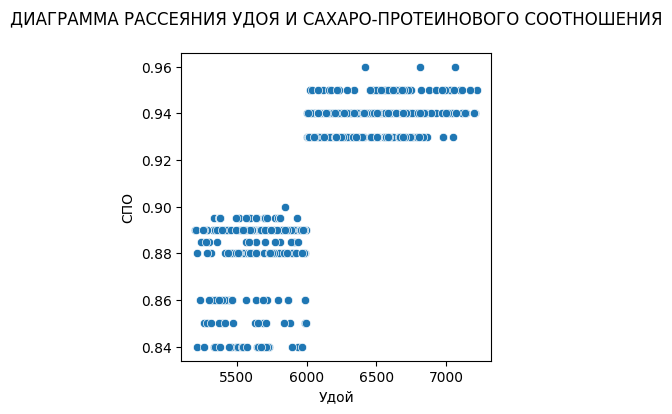

In [85]:
# выведем еще раз график рассеяния параметров СПО и Удой
plt.figure(figsize=(4, 4))
graph = sns.scatterplot(data=ferma_main_2, x='milk_yield', y='sugar_protein_ratio')
plt.title('Диаграмма рассеяния удоя и сахаро-протеинового соотношения\n'.upper())
plt.xlabel('Удой')
plt.ylabel('СПО');

In [86]:
# в качестве границы разделения выберем среднее значение 
statistics.mean([0.93, 0.9])

0.915

In [87]:
# создадим функцию для создания категориального признака
def make_spo_category(ratio):
    limit = statistics.mean([0.93, 0.9])
    
    if ratio > limit:
        return 'выше_границы'
    elif ratio < limit:
        return 'ниже_границы'
    else:
        raise Exception("Требуется изменить лимиты")

# сделаем категориальный признак
ferma_main_2['spo_category'] = ferma_main_2['sugar_protein_ratio'].apply(make_spo_category)

# проверим, что функция применилась корректно
ferma_main_2.head(10)

id  milk_yield  energy_feed_unit  raw_protein  sugar_protein_ratio  \
0   1        5863              14.2         1743                0.890   
1   2        5529              12.8         2138                0.890   
2   3        5810              14.0         1854                0.885   
3   4        5895              12.4         2012                0.885   
4   5        5302              12.8         1675                0.885   
5   6        5254              12.7         1806                0.885   
6   7        5910              13.2         1792                0.885   
7   8        6179              14.7         1806                0.930   
8   9        6783              14.2         1918                0.940   
9  10        5339              13.4         1791                0.895   

             breed pasture_type dad_bull_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное         Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинное        Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое        Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое         Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинное        Соверин         3.73    3.073   
5  РефлешнСоверинг    Холмистое        Соверин         3.13    3.078   
6   Вис Бик Айдиал    Равнинное        Соверин         3.48    3.077   
7   Вис Бик Айдиал    Равнинное         Айдиал         3.55    3.076   
8  РефлешнСоверинг    Холмистое         Айдиал         3.71    3.077   
9   Вис Бик Айдиал    Холмистое        Соверин         3.13    3.075   

  milk_taste          age  EFU_squared  spo_category  
0     вкусно  более_2_лет       201.64  ниже_границы  
1     вкусно  менее_2_лет       163.84  ниже_границы  
2  не вкусно  более_2_лет       196.00  ниже_границы  
3  не вкусно  более_2_лет       153.76  ниже_границы  
4     вкусно  менее_2_лет       163.84  ниже_границы  
5     вкусно  менее_2_лет       161.29  ниже_границы  
6     вкусно  более_2_лет       174.24  ниже_границы  
7     вкусно  более_2_лет       216.09  выше_границы  
8     вкусно  более_2_лет       201.64  выше_границы  
9     вкусно  менее_2_лет       179.56  ниже_границы

In [88]:
# посмотрим соотношение
ferma_main_2['spo_category'].value_counts()

spo_category
выше_границы    363
ниже_границы    249
Name: count, dtype: int64

In [89]:
ferma_main_2 = ferma_main_2[['milk_yield', 'raw_protein', 'breed', 'pasture_type', 'dad_bull_breed', 'age', 'EFU_squared', 'spo_category']]
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age', 'spo_category']
count_col_names = ['EFU_squared', 'raw_protein']

# сохранение входных признаков в переменную X
X = ferma_main_2.drop('milk_yield', axis=1)

# сохранение целевого признака в переменную y
y = ferma_main_2['milk_yield']

# создание константы RANDOM_STATE
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

# вывод необходимых размерностей
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(459, 7)
(153, 7)
(459,)
(153,)


In [90]:
# выбор способа кодирования
try: 
    encoder = OneHotEncoder(drop='first', sparse=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 

# кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# посмотрим список новых столбцов
try: 
    encoder_col_names = encoder.get_feature_names() 
except:
    encoder_col_names = encoder.get_feature_names_out() 

encoder_col_names

array(['breed_РефлешнСоверинг', 'pasture_type_Холмистое',
       'dad_bull_breed_Соверин', 'age_менее_2_лет',
       'spo_category_ниже_границы'], dtype=object)

In [91]:
# выбор способа масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[count_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[count_col_names]) 

In [92]:
# объединение массивов
X_train = np.hstack([X_train_ohe, X_train_scaled])
X_test = np.hstack([X_test_ohe, X_test_scaled])

### Обучение модели

In [93]:
model_lr = LinearRegression() 

model_lr.fit(X_train, y_train) 

predictions = model_lr.predict(X_test) 

### Оценка работы модели

In [94]:
# посчитаем показатель R²
r2 = r2_score(y_test, predictions)  
all_r2['2'] = r2
r2

0.8316394873761661

### Анализ остатков

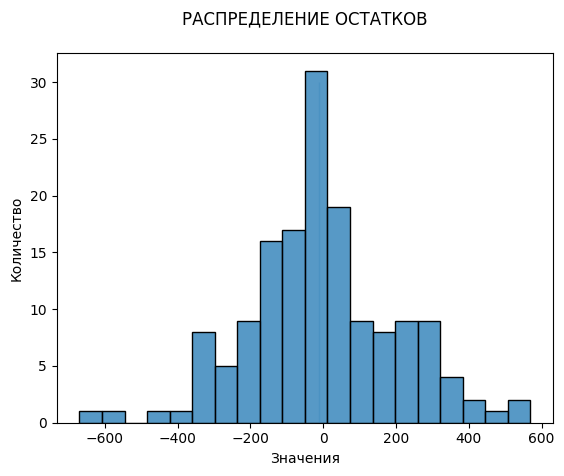

In [95]:
# построим гистограмму распределения остатков
residuals_2 = y_test - predictions
sns.histplot(residuals_2, bins=20)
sns.lineplot(x = residuals_2.median(), y=[0, 30])
plt.title('Распределение остатков\n'.upper())
plt.xlabel('Значения')
plt.ylabel('Количество');

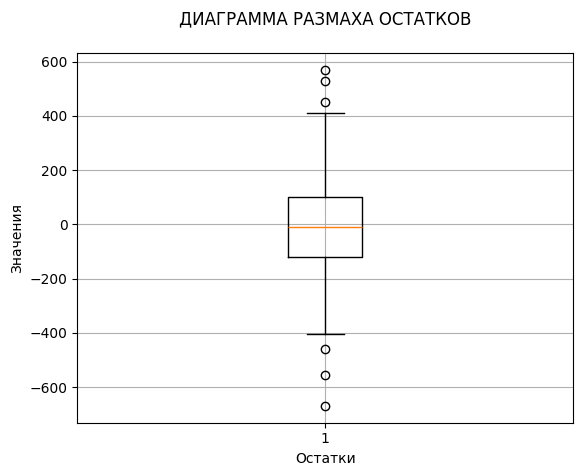

In [96]:
# построим диаграмму разамаха
plt.boxplot(residuals_2)
plt.title('Диаграмма размаха остатков\n'.upper())
plt.grid()
plt.xlabel('Остатки')
plt.ylabel('Значения');

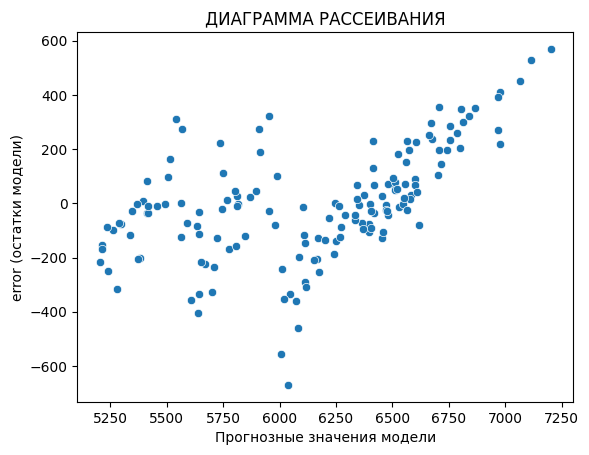

In [97]:
# построим диаграмму рассеивания остатков
graph = sns.scatterplot(x=y_test, y=residuals_2)
plt.title('Диаграмма рассеивания'.upper())
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error (остатки модели)');

### Оценка качества модели

In [98]:
mae = mean_absolute_error(y_test, predictions) 

try:
    rmse = mean_squared_error(y_test, predictions, squared=False) 
except:
    rmse = root_mean_squared_error(y_test, predictions)

mse = mean_squared_error(y_test, predictions)

all_mae['model_2'] = mae
all_rmse['model_2'] = rmse
all_mse['model_2'] = mse

**Вывод**

Мы получили значение коэффициента детерминации = 0.8316. Можно сказать, что модель достаточно неплохо предсказывает целевой признак по входным данным. Лучше, чем модель № 1. 

Анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания похоже на линейное). Можно сказать, что модель работает хорошо. 

## №3. Обучение модели линейной регрессии

### Подготовка данных

**Целевой признак: Удой**

Для обучения модели линейной регрессии будем использовать признаки:
1. Количественные:
- ЭКЕ `energy_feed_unit` (после подготовки)
- Сырой протеин `raw_protein`
2. Категориальные:
- Порода `breed`
- Тип пастбища `pasture_type`
- Порода папы-быка `dad_bull_breed`
- Возраст коровы `age`
- СПО `sugar_protein_ratio` (после подготовки)
- Имя папы-быка `dad_bull_name`

Параметр жирность и вкус молока не используем для обучения, так как это характеристики полученного молока, т.е. параметр не может влиять на удой. 

In [99]:
# объединим датафрейм с данными из файла ferma_dad.csv
ferma_main_3 = ferma_main.merge(ferma_dad, on='id')

# переименуем столбцы
ferma_main_3 = ferma_main_3.rename(columns={'dad_bull_breed_x':'dad_bull_breed',
                        'dad_bull_breed_y': 'dad_bull_name'})

# проверим корректно ли произошло объединение
ferma_main_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   612 non-null    int64  
 1   milk_yield           612 non-null    int64  
 2   energy_feed_unit     612 non-null    float64
 3   raw_protein          612 non-null    int64  
 4   sugar_protein_ratio  612 non-null    float64
 5   breed                612 non-null    object 
 6   pasture_type         612 non-null    object 
 7   dad_bull_breed       612 non-null    object 
 8   fat_content          612 non-null    float64
 9   protein              612 non-null    float64
 10  milk_taste           612 non-null    object 
 11  age                  612 non-null    object 
 12  dad_bull_name        612 non-null    object 
dtypes: float64(4), int64(3), object(6)
memory usage: 62.3+ KB


In [100]:
# введем новый параметр - ЭКЕ в квадрате
ferma_main_3['EFU_squared'] = ferma_main_3['energy_feed_unit'] ** 2

# проверим, что изменения внесены корректно
ferma_main_3.head()

id  milk_yield  energy_feed_unit  raw_protein  sugar_protein_ratio  \
0   1        5863              14.2         1743                0.890   
1   2        5529              12.8         2138                0.890   
2   3        5810              14.0         1854                0.885   
3   4        5895              12.4         2012                0.885   
4   5        5302              12.8         1675                0.885   

             breed pasture_type dad_bull_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное         Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинное        Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое        Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое         Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинное        Соверин         3.73    3.073   

  milk_taste          age dad_bull_name  EFU_squared  
0     вкусно  более_2_лет        Буйный       201.64  
1     вкусно  менее_2_лет      Соловчик       163.84  
2  не вкусно  более_2_лет         Барин       196.00  
3  не вкусно  более_2_лет        Буйный       153.76  
4     вкусно  менее_2_лет         Барин       163.84

In [101]:
ferma_main_3['spo_category'] = ferma_main_3['sugar_protein_ratio'].apply(make_spo_category)

# проверим, что функция применилась корректно
ferma_main_3.head(10)

id  milk_yield  energy_feed_unit  raw_protein  sugar_protein_ratio  \
0   1        5863              14.2         1743                0.890   
1   2        5529              12.8         2138                0.890   
2   3        5810              14.0         1854                0.885   
3   4        5895              12.4         2012                0.885   
4   5        5302              12.8         1675                0.885   
5   6        5254              12.7         1806                0.885   
6   7        5910              13.2         1792                0.885   
7   8        6179              14.7         1806                0.930   
8   9        6783              14.2         1918                0.940   
9  10        5339              13.4         1791                0.895   

             breed pasture_type dad_bull_breed  fat_content  protein  \
0   Вис Бик Айдиал    Равнинное         Айдиал         3.58    3.076   
1   Вис Бик Айдиал    Равнинное        Соверин         3.54    3.079   
2  РефлешнСоверинг    Холмистое        Соверин         3.59    3.074   
3  РефлешнСоверинг    Холмистое         Айдиал         3.40    3.075   
4   Вис Бик Айдиал    Равнинное        Соверин         3.73    3.073   
5  РефлешнСоверинг    Холмистое        Соверин         3.13    3.078   
6   Вис Бик Айдиал    Равнинное        Соверин         3.48    3.077   
7   Вис Бик Айдиал    Равнинное         Айдиал         3.55    3.076   
8  РефлешнСоверинг    Холмистое         Айдиал         3.71    3.077   
9   Вис Бик Айдиал    Холмистое        Соверин         3.13    3.075   

  milk_taste          age dad_bull_name  EFU_squared  spo_category  
0     вкусно  более_2_лет        Буйный       201.64  ниже_границы  
1     вкусно  менее_2_лет      Соловчик       163.84  ниже_границы  
2  не вкусно  более_2_лет         Барин       196.00  ниже_границы  
3  не вкусно  более_2_лет        Буйный       153.76  ниже_границы  
4     вкусно  менее_2_лет         Барин       163.84  ниже_границы  
5     вкусно  менее_2_лет         Барин       161.29  ниже_границы  
6     вкусно  более_2_лет      Соловчик       174.24  ниже_границы  
7     вкусно  более_2_лет      Геркулес       216.09  выше_границы  
8     вкусно  более_2_лет        Буйный       201.64  выше_границы  
9     вкусно  менее_2_лет         Барин       179.56  ниже_границы

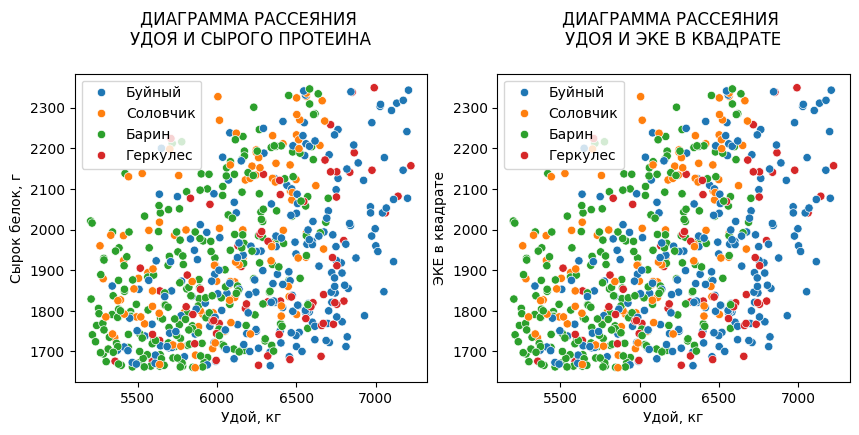

In [102]:
# посмотрим на распределение признаков
plt.figure(figsize=(10, 4))
plt.axis('off')

plt.subplot(1, 2, 1)
graph = sns.scatterplot(data=ferma_main_3, x='milk_yield', y='raw_protein', hue='dad_bull_name');
plt.title('Диаграмма рассеяния \nудоя и сырого протеина\n'.upper())
graph.legend()
plt.xlabel('Удой, кг')
plt.ylabel('Сырок белок, г');

plt.subplot(1, 2, 2)
graph = sns.scatterplot(data=ferma_main_3, x='milk_yield', y='raw_protein', hue='dad_bull_name');
plt.title('Диаграмма рассеяния \nудоя и ЭКЕ в квадрате\n'.upper())
graph.legend()
plt.xlabel('Удой, кг')
plt.ylabel('ЭКЕ в квадрате');

In [103]:
ferma_main_3 = ferma_main_3[['milk_yield', 'raw_protein', 'breed', 'pasture_type', 'dad_bull_breed', 'age', 'EFU_squared', 'spo_category', 'dad_bull_name']]
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age', 'spo_category', 'dad_bull_name']
count_col_names = ['EFU_squared', 'raw_protein']

# сохранение входных признаков в переменную X
X = ferma_main_3.drop(columns=['milk_yield'])

# сохранение целевого признака в переменную y
y = ferma_main['milk_yield']

# создание константы RANDOM_STATE
RANDOM_STATE = 42

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

# вывод необходимых размерностей
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(459, 8)
(153, 8)
(459,)
(153,)


In [104]:
# выбор способа кодирования
try: 
    encoder = OneHotEncoder(drop='first', sparse=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 

# кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# посмотрим список новых столбцов
try: 
    encoder_col_names = encoder.get_feature_names() 
except:
    encoder_col_names = encoder.get_feature_names_out() 
    
encoder_col_names

array(['breed_РефлешнСоверинг', 'pasture_type_Холмистое',
       'dad_bull_breed_Соверин', 'age_менее_2_лет',
       'spo_category_ниже_границы', 'dad_bull_name_Буйный',
       'dad_bull_name_Геркулес', 'dad_bull_name_Соловчик'], dtype=object)

In [105]:
# выбор способа масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[count_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[count_col_names]) 

In [106]:
# объединение массивов
X_train = np.hstack([X_train_ohe, X_train_scaled])
X_test = np.hstack([X_test_ohe, X_test_scaled])

### Обучение модели

In [107]:
model_lr = LinearRegression() 

model_lr.fit(X_train, y_train) 

predictions = model_lr.predict(X_test) 

### Оценка работы модели

In [108]:
# посчитаем показатель R²
r2 = r2_score(y_test, predictions)  
all_r2['3'] = r2
r2

0.845708149194399

### Анализ остатков

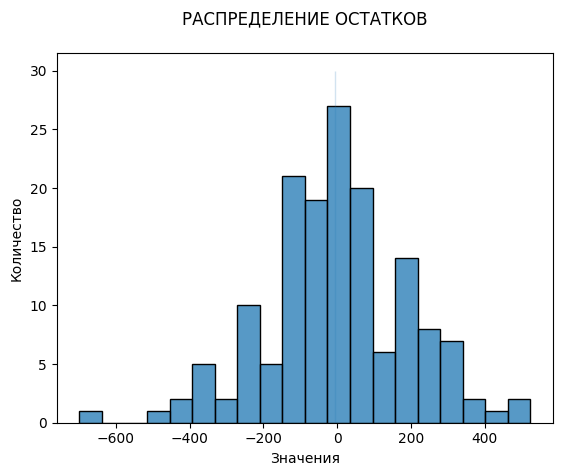

In [109]:
# построим гистограмму распределения остатков
residuals_3 = y_test - predictions
sns.histplot(residuals_3, bins=20)
sns.lineplot(x = residuals_3.median(), y=[0, 30])
plt.title('Распределение остатков\n'.upper())
plt.xlabel('Значения')
plt.ylabel('Количество');

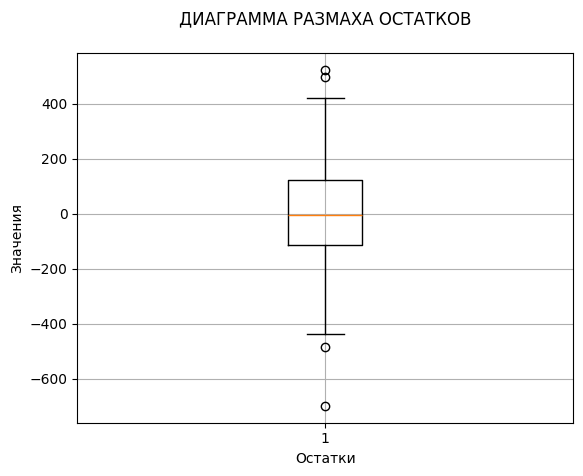

In [110]:
# построим диаграмму разамаха
plt.boxplot(residuals_3)
plt.title('Диаграмма размаха остатков\n'.upper())
plt.grid()
plt.xlabel('Остатки')
plt.ylabel('Значения');

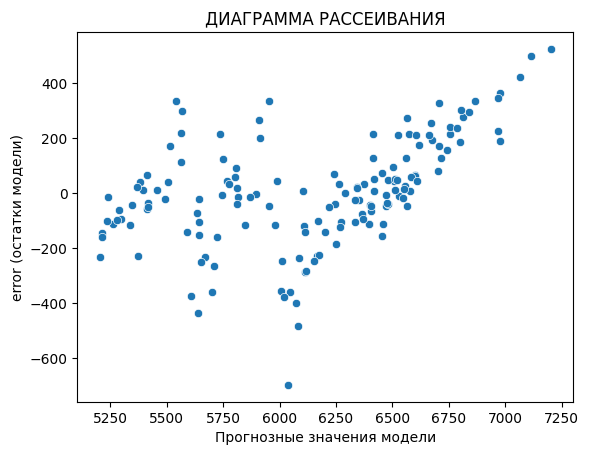

In [111]:
# построим диаграмму рассеивания остатков
graph = sns.scatterplot(x=y_test, y=residuals_3)
plt.title('Диаграмма рассеивания'.upper())
plt.xlabel('Прогнозные значения модели')
plt.ylabel('error (остатки модели)');

### Оценка качества модели

In [112]:
mae = mean_absolute_error(y_test, predictions) 

try:
    rmse = mean_squared_error(y_test, predictions, squared=False) 
except:
    rmse = root_mean_squared_error(y_test, predictions)

mse = mean_squared_error(y_test, predictions)

all_mae['model_3'] = mae
all_rmse['model_3'] = rmse
all_mse['model_3'] = mse

**Вывод**

Мы получили значение коэффициента детерминации = 0.8457. Можно сказать, что модель достаточно неплохо предсказывает целевой признак по входным данным. Лучше, чем модель № 1 и № 2.

Анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания похоже на линейное). Можно также сказать, что модель работает хорошо. 

## Сравнение моделей

### Сопоставление R² и остатков

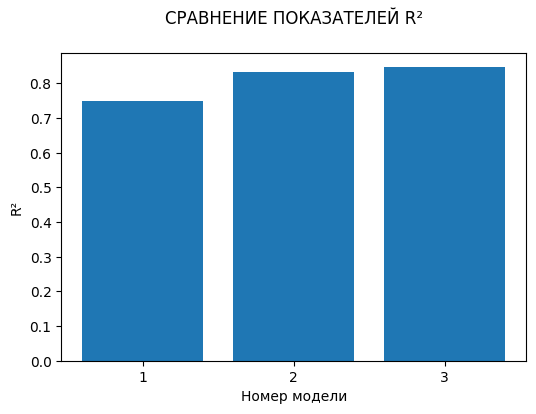

In [113]:
plt.figure(figsize=(6, 4))
plt.bar(height = all_r2.values(), x=all_r2.keys())
plt.title('Сравнение показателей R²\n'.upper())
plt.xlabel('Номер модели')
plt.ylabel('R²');

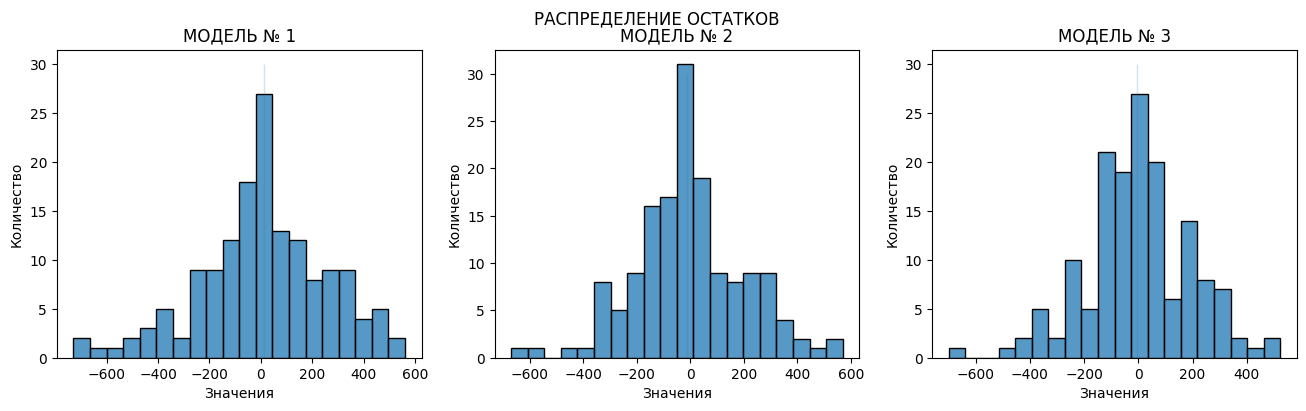

In [114]:
# построим гистограмму распределения остатков для каждой модели
plt.figure(figsize=(16, 4))
plt.suptitle('Распределение остатков\n\n'.upper())
plt.axis('off')

plt.subplot(1, 3, 1)
plt.title('Модель № 1'.upper())
sns.histplot(residuals_1, bins=20)
sns.lineplot(x = residuals_1.median(), y=[0, 30])
plt.xlabel('Значения')
plt.ylabel('Количество')

plt.subplot(1, 3, 2)
plt.title('Модель № 2'.upper())
sns.histplot(residuals_2, bins=20)
sns.lineplot(x = residuals_2.median(), y=[0, 30])
plt.xlabel('Значения')
plt.ylabel('Количество')

plt.subplot(1, 3, 3)
plt.title('Модель № 3'.upper())
sns.histplot(residuals_3, bins=20)
sns.lineplot(x = residuals_3.median(), y=[0, 30])
plt.xlabel('Значения')
plt.ylabel('Количество');

Лучший показатель R² у модели № 3. Худший - у модели № 1. 

Для всех моделей актуально нормальное распределение остатков и среднее значениие остатков близкое к 0.  

### Оценка качества моделей по трем метрикам

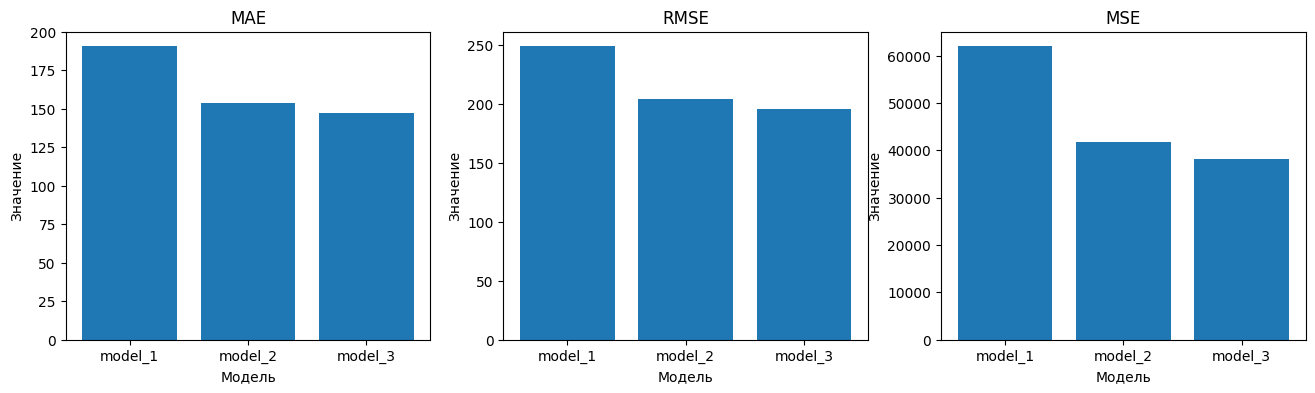

In [115]:
plt.figure(figsize=(16, 4))

plt.subplot(1, 3, 1)
plt.bar(height = all_mae.values(), x=all_mae.keys())
plt.title('MAE')
plt.xlabel('Модель')
plt.ylabel('Значение')

plt.subplot(1, 3, 2)
plt.bar(height = all_rmse.values(), x=all_rmse.keys())
plt.title('RMSE')
plt.xlabel('Модель')
plt.ylabel('Значение')

plt.subplot(1, 3, 3)
plt.bar(height = all_mse.values(), x=all_mse.keys())
plt.title('MSE')
plt.xlabel('Модель')
plt.ylabel('Значение');

**Вывод**

- **MAE** - значение средней абсолютной ошибки максимальное для модели № 1, минимальное для модели № 3. 
- **RMSE** - значение квадратного корня из среднеквадратичной ошибки максимальное для модели № 1, минимальное для модели № 3.
- **MSE** - значение среднеквадратичной ошибки максимальное для модели № 1, минимальное для модели № 3. 

Так как чем меньше значения MSE, RMSE и MAE, тем точнее модель, для прогноза удоя коров выбираем модель № 3. 

In [116]:
# посчитаем доверительный интервал для 3 модели
errors = y_test - predictions
quantiles=(0.025, 0.975)

lower_quantile = np.quantile(errors, quantiles[0])
upper_quantile = np.quantile(errors, quantiles[1])

print(f"Доверительный интервал прогноза: [{lower_quantile}, {upper_quantile}]")

Доверительный интервал прогноза: [-383.3392266082277, 349.44754986382264]


In [117]:
print('95% доверительный интервал =',
      st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions)))

95% доверительный интервал = (np.float64(6068.076877421743), np.float64(6208.754596436998))


## Прогноз удоя коров

### Добавление недостающих признаков

In [118]:
# добавим недостающие признаки ЭКЕ (Энергетическая кормовая единица), Сырой протеин, г и СПО (Сахаро-протеиновое соотношение)
# посчитаем средние значения показателей + 5%
efu = ferma_main['energy_feed_unit'].mean() + 0.05 * ferma_main['energy_feed_unit'].mean()
raw_protein = ferma_main['raw_protein'].mean() + 0.05 * ferma_main['raw_protein'].mean()
spo = ferma_main['sugar_protein_ratio'].mean() + 0.05 * ferma_main['sugar_protein_ratio'].mean()

In [119]:
# добавим посчитанные значения в датафрейм от Фермы
cow_buy_predict = cow_buy.copy()

cow_buy_predict['efu'] = efu
cow_buy_predict['raw_protein'] = raw_protein
cow_buy_predict['spo'] = spo

# проверим, что данные добавили корректно
cow_buy_predict.head()

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
0   Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
1   Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.54   
2  РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
3  РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
4  РефлешнСоверинг    Равнинное         Айдиал        Буйный         3.64   

   protein          age        efu  raw_protein      spo  
0    3.076  более_2_лет  15.271152  2018.417402  0.95888  
1    3.081  менее_2_лет  15.271152  2018.417402  0.95888  
2    3.074  более_2_лет  15.271152  2018.417402  0.95888  
3    3.061  более_2_лет  15.271152  2018.417402  0.95888  
4    3.074  более_2_лет  15.271152  2018.417402  0.95888

### Подготовка данных

In [120]:
# введем новый параметр - ЭКЕ в квадрате
cow_buy_predict['EFU_squared'] = cow_buy_predict['efu'] ** 2

# проверим, что изменения внесены корректно
cow_buy_predict.head()

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
0   Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
1   Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.54   
2  РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
3  РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
4  РефлешнСоверинг    Равнинное         Айдиал        Буйный         3.64   

   protein          age        efu  raw_protein      spo  EFU_squared  
0    3.076  более_2_лет  15.271152  2018.417402  0.95888   233.208082  
1    3.081  менее_2_лет  15.271152  2018.417402  0.95888   233.208082  
2    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082  
3    3.061  более_2_лет  15.271152  2018.417402  0.95888   233.208082  
4    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082

In [121]:
# сделаем СПО категориальным признаком применив функцию, созданную ранее
cow_buy_predict['spo_category'] = cow_buy_predict['spo'].apply(make_spo_category)

# проверим, что функция применилась корректно
cow_buy_predict.head(10)

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
0   Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
1   Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.54   
2  РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
3  РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
4  РефлешнСоверинг    Равнинное         Айдиал        Буйный         3.64   
5  РефлешнСоверинг    Равнинное        Соверин      Геркулес         3.63   
6   Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
7   Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.57   
8  РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
9  РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   

   protein          age        efu  raw_protein      spo  EFU_squared  \
0    3.076  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
1    3.081  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
2    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
3    3.061  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
4    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
5    3.053  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
6    3.076  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
7    3.079  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
8    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
9    3.079  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   

   spo_category  
0  выше_границы  
1  выше_границы  
2  выше_границы  
3  выше_границы  
4  выше_границы  
5  выше_границы  
6  выше_границы  
7  выше_границы  
8  выше_границы  
9  выше_границы

### Прогноз

In [122]:
df_to_predict = cow_buy_predict[['breed', 'raw_protein', 'pasture_type', 'dad_bull_breed', 'dad_bull_name', 'age', 'EFU_squared', 'spo_category']].copy()
cat_col_names = ['breed', 'pasture_type', 'dad_bull_breed', 'age', 'spo_category', 'dad_bull_name']
count_col_names = ['EFU_squared', 'raw_protein']

In [123]:
# кодирование выборки
X_ohe = encoder.transform(df_to_predict[cat_col_names]) 

# масштабирование выборки
X_scaled = scaler.transform(df_to_predict[count_col_names]) 

# объединение массивов
X = np.hstack([X_ohe, X_scaled])

# прогноз
cow_buy_predict.loc[:, 'milk_yield_predict'] = model_lr.predict(X) 

In [124]:
# выведем полученные результаты
cow_buy_predict

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
0    Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
1    Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.54   
2   РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
3   РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
4   РефлешнСоверинг    Равнинное         Айдиал        Буйный         3.64   
5   РефлешнСоверинг    Равнинное        Соверин      Геркулес         3.63   
6    Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.58   
7    Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.57   
8   РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
9   РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
10   Вис Бик Айдиал    Холмистое        Соверин      Соловчик         3.73   
11  РефлешнСоверинг    Равнинное        Соверин      Геркулес         3.73   
12   Вис Бик Айдиал    Холмистое         Айдиал      Геркулес         3.68   
13   Вис Бик Айдиал    Холмистое        Соверин         Барин         3.42   
14  РефлешнСоверинг    Равнинное        Соверин         Барин         3.59   
15  РефлешнСоверинг    Холмистое         Айдиал        Буйный         3.40   
16   Вис Бик Айдиал    Холмистое        Соверин      Соловчик         3.73   
17  РефлешнСоверинг    Равнинное        Соверин      Геркулес         3.77   
18   Вис Бик Айдиал    Равнинное        Соверин        Буйный         3.34   
19  РефлешнСоверинг    Равнинное         Айдиал        Буйный         3.64   

    protein          age        efu  raw_protein      spo  EFU_squared  \
0     3.076  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
1     3.081  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
2     3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
3     3.061  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
4     3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
5     3.053  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
6     3.076  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
7     3.079  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
8     3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
9     3.079  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
10    3.055  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
11    3.073  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
12    3.046  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
13    3.075  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
14    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
15    3.065  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
16    3.079  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
17    3.053  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   
18    3.069  более_2_лет  15.271152  2018.417402  0.95888   233.208082   
19    3.074  более_2_лет  15.271152  2018.417402  0.95888   233.208082   

    spo_category  milk_yield_predict  
0   выше_границы         6581.731529  
1   выше_границы         6317.706397  
2   выше_границы         6284.425388  
3   выше_границы         6593.829776  
4   выше_границы         6535.591403  
5   выше_границы         6354.939992  
6   выше_границы         6581.731529  
7   выше_границы         6542.483128  
8   выше_границы         6284.425388  
9   выше_границы         6369.053045  
10  выше_границы         6359.444876  
11  выше_границы         6579.716723  
12  выше_границы         6581.731529  
13  выше_границы         6093.221109  
14  выше_границы         6284.425388  
15  выше_границы         6593.829776  
16  выше_границы         6359.444876  
17  выше_границы         6354.939992  
18  выше_границы         6542.483128  
19  выше_границы         6535.591403

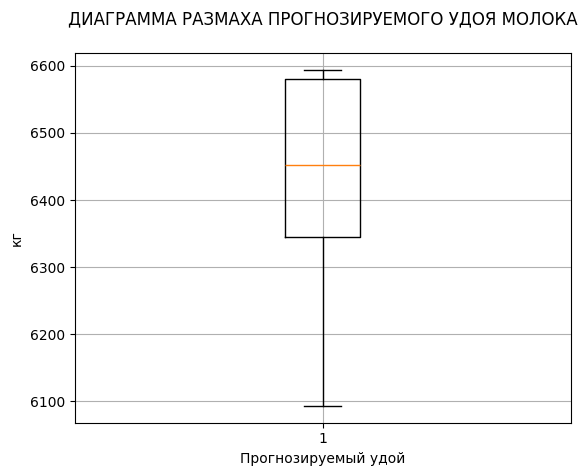

In [125]:
# построим диаграмму разамаха
plt.boxplot(cow_buy_predict['milk_yield_predict'])
plt.title('Диаграмма размаха прогнозируемого удоя молока\n'.upper())
plt.grid()
plt.xlabel('Прогнозируемый удой')
plt.ylabel('кг');

In [126]:
cow_buy_predict['milk_yield_predict'].describe()

count      20.000000
mean     6436.537319
std       146.261571
min      6093.221109
25%      6345.631593
50%      6452.322224
75%      6580.220425
max      6593.829776
Name: milk_yield_predict, dtype: float64

**Вывод**

Были получены результаты прогнозирования удоя молока на основе модели № 3. 

Прогнозируемые значения варьируются от минимального 6093 кг до максимального 6593,8 кг, что полностью удовлетворяет запрос фермера (более 6000 кг молока в год).

## Задача классификации

**Целевой признак - Вкус молока**

### Подготовка данных

In [127]:
# подготовим датафрейм со всеми возможными признаками
ferma_main_class = ferma_main_3.merge(ferma_main[['milk_yield', 'raw_protein', 'breed', 'fat_content', 'protein', 'milk_taste']], on=['milk_yield', 'raw_protein', 'breed'])

# проверим корректность объединения
ferma_main_class.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   milk_yield      612 non-null    int64  
 1   raw_protein     612 non-null    int64  
 2   breed           612 non-null    object 
 3   pasture_type    612 non-null    object 
 4   dad_bull_breed  612 non-null    object 
 5   age             612 non-null    object 
 6   EFU_squared     612 non-null    float64
 7   spo_category    612 non-null    object 
 8   dad_bull_name   612 non-null    object 
 9   fat_content     612 non-null    float64
 10  protein         612 non-null    float64
 11  milk_taste      612 non-null    object 
dtypes: float64(3), int64(2), object(7)
memory usage: 57.5+ KB


In [128]:
# внесем корректировку в целевой признак
ferma_main_class['milk_taste'] = ferma_main_class['milk_taste'].apply(lambda x: 1 if x == 'вкусно' else 0)

In [129]:
cat_col_names = ['breed', 'pasture_type', 'age', 'spo_category', 'dad_bull_breed', 'dad_bull_name']
count_col_names = [ 'EFU_squared', 'fat_content', 'raw_protein', 'protein']

# сохранение входных признаков в переменную X
X = ferma_main_class.drop(columns=['milk_taste', 'milk_yield'])

# сохранение целевого признака в переменную y
y = ferma_main_class['milk_taste']

# создание константы RANDOM_STATE
RANDOM_STATE = 50

# разделение на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
) 

# вывод необходимых размерностей
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(459, 10)
(153, 10)
(459,)
(153,)


In [130]:
# выбор способа кодирования
try: 
    encoder = OneHotEncoder(drop='first', sparse=False) 
except:
    encoder = OneHotEncoder(drop='first', sparse_output=False) 

# кодирование тренировочной выборки
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])

# кодирование тестовой выборки
X_test_ohe = encoder.transform(X_test[cat_col_names]) 

# посмотрим список новых столбцов
try: 
    encoder_col_names = encoder.get_feature_names() 
except:
    encoder_col_names = encoder.get_feature_names_out() 
    
encoder_col_names

array(['breed_РефлешнСоверинг', 'pasture_type_Холмистое',
       'age_менее_2_лет', 'spo_category_ниже_границы',
       'dad_bull_breed_Соверин', 'dad_bull_name_Буйный',
       'dad_bull_name_Геркулес', 'dad_bull_name_Соловчик'], dtype=object)

In [131]:
# выбор способа масштабирования
scaler = StandardScaler()

# настройка и масштабирование тренировочной выборки
X_train_scaled = scaler.fit_transform(X_train[count_col_names])

# масштабирование тестовой выборки
X_test_scaled = scaler.transform(X_test[count_col_names]) 

In [132]:
# объединение массивов
X_train = np.hstack([X_train_ohe, X_train_scaled])
X_test = np.hstack([X_test_ohe, X_test_scaled])

### Обучение модели

In [133]:
# создаём объект для работы с моделью
clf = LogisticRegression()

# настраиваем модель на данные
clf = clf.fit(X_train, y_train)

# получаем прогнозные значения
y_pred = clf.predict(X_test) 

### Оценка качества модели

In [134]:
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)

print('accuracy: ',round(accuracy ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('specificity: ',round(specificity,3))

accuracy:  0.627
recall:  0.811
precision:  0.646
specificity:  0.365


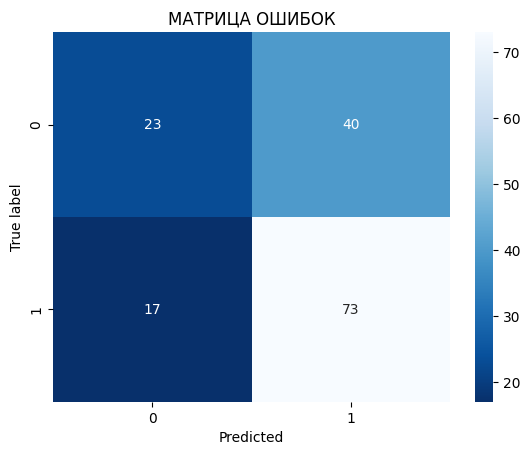

In [135]:
# построим матрицу ошибок
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок'.upper())
plt.ylabel('True label')
plt.xlabel('Predicted'); 

In [136]:
# посмотрим на веса признаков
for feature_number, feature_name in enumerate(X.columns):
    exp_weight = math.exp(clf.coef_[0, feature_number])
    print(f"{feature_name:<20}: {exp_weight:+.6f}") 

raw_protein         : +0.854775
breed               : +2.014428
pasture_type        : +1.004571
dad_bull_breed      : +2.738049
age                 : +0.803442
EFU_squared         : +0.885800
spo_category        : +0.716540
dad_bull_name       : +0.710402
fat_content         : +2.016490
protein             : +0.991470


Точность модели (`accuracy`) составляет 63%. 

В текущей модели превалируют ошибки 1-го рода, т.е. когда модель классифицирует невкусное молоко как вкусное. 

При этом True Positive результаты получились в 73 случаях, а True Negative в 23. 

Для решения задачи по предсказанию вкусного молока критичнее ошибки 1-го рода, т.е. назвать невкусное молоко вкусным.

Таким образом необходимо увеличить значение метрики `precision`. 

Текущее значение метрики precision = 0.646

In [137]:
# выведем объекты по убыванию вероятности их принадлежности к классу 1
y_proba = clf.predict_proba(X_test)[:,1]

data = pd.DataFrame(zip(y_test, y_proba),
             columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False)

print(data.head()) 

     y_valid   y_proba
52         1  0.887187
140        1  0.870500
20         1  0.865372
96         1  0.862695
56         1  0.858062


In [138]:
# создадим пороговые значения в промежутке от 0.1 до 1
thresholds = [round(i,2) for i in np.linspace(0.1,1,num = 7,endpoint=False)]

# создадим переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
	columns.append('y_pred_'+str(i))
	data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>=i else 0)

# выведем 5 случайных строк
data.sample(5)

y_valid   y_proba  y_pred_0.1  y_pred_0.23  y_pred_0.36  y_pred_0.49  \
46         0  0.548085           1            1            1            1   
28         1  0.727084           1            1            1            1   
121        1  0.327120           1            1            0            0   
50         0  0.485859           1            1            1            0   
19         1  0.798499           1            1            1            1   

     y_pred_0.61  y_pred_0.74  y_pred_0.87  
46             0            0            0  
28             1            0            0  
121            0            0            0  
50             0            0            0  
19             1            1            0

In [139]:
# получим значение precision
for i in thresholds:
    print('y_pred_{0}_precision: '.format(str(i)), precision_score(y_test, data['y_pred_{}'.format(str(i))]))

y_pred_0.1_precision:  0.5882352941176471
y_pred_0.23_precision:  0.5921052631578947
y_pred_0.36_precision:  0.5902777777777778
y_pred_0.49_precision:  0.5689655172413793
y_pred_0.61_precision:  0.5507246376811594
y_pred_0.74_precision:  0.5769230769230769
y_pred_0.87_precision:  1.0


In [140]:
# создадим пороговые значения в промежутке от 0.74 до 0.87
thresholds = [round(i,2) for i in np.linspace(0.74,0.88,num = 14,endpoint=False)]

# создадим переменную, которая будет хранить список новых колонок
columns = []

# добавим столбцы с новыми предсказаниями в таблицу
for i in thresholds:
	columns.append('y_pred_'+str(i))
	data['y_pred_'+str(i)] = data['y_proba'].apply(lambda x: 1 if x>=i else 0)

# выведем 5 случайных строк
data.sample(5)

y_valid   y_proba  y_pred_0.1  y_pred_0.23  y_pred_0.36  y_pred_0.49  \
32         0  0.519350           1            1            1            1   
122        1  0.338886           1            1            0            0   
118        0  0.585565           1            1            1            1   
115        1  0.441635           1            1            1            0   
80         1  0.826566           1            1            1            1   

     y_pred_0.61  y_pred_0.74  y_pred_0.87  y_pred_0.75  ...  y_pred_0.77  \
32             0            0            0            0  ...            0   
122            0            0            0            0  ...            0   
118            0            0            0            0  ...            0   
115            0            0            0            0  ...            0   
80             1            1            0            1  ...            1   

     y_pred_0.78  y_pred_0.79  y_pred_0.8  y_pred_0.81  y_pred_0.82  \
32             0            0           0            0            0   
122            0            0           0            0            0   
118            0            0           0            0            0   
115            0            0           0            0            0   
80             1            1           1            1            1   

     y_pred_0.83  y_pred_0.84  y_pred_0.85  y_pred_0.86  
32             0            0            0            0  
122            0            0            0            0  
118            0            0            0            0  
115            0            0            0            0  
80             0            0            0            0  

[5 rows x 21 columns]

In [141]:
for i in thresholds:
    print('y_pred_{0}_precision: '.format(str(i)), precision_score(y_test, data['y_pred_{}'.format(str(i))]))

y_pred_0.74_precision:  0.5769230769230769
y_pred_0.75_precision:  0.6
y_pred_0.76_precision:  0.55
y_pred_0.77_precision:  0.5625
y_pred_0.78_precision:  0.6
y_pred_0.79_precision:  0.5714285714285714
y_pred_0.8_precision:  0.5
y_pred_0.81_precision:  0.4
y_pred_0.82_precision:  0.5
y_pred_0.83_precision:  0.5
y_pred_0.84_precision:  0.4
y_pred_0.85_precision:  0.4
y_pred_0.86_precision:  0.5
y_pred_0.87_precision:  1.0


In [142]:
for i in thresholds:
    tn, fp, fn, tp = confusion_matrix(y_test, data['y_pred_{}'.format(str(i))]).ravel()
    specificity = tn / (tn+fp)
    print('y_pred_{0}_specificity: '.format(str(i)), specificity)

y_pred_0.74_specificity:  0.8253968253968254
y_pred_0.75_specificity:  0.8412698412698413
y_pred_0.76_specificity:  0.8571428571428571
y_pred_0.77_specificity:  0.8888888888888888
y_pred_0.78_specificity:  0.9047619047619048
y_pred_0.79_specificity:  0.9047619047619048
y_pred_0.8_specificity:  0.9047619047619048
y_pred_0.81_specificity:  0.9047619047619048
y_pred_0.82_specificity:  0.9365079365079365
y_pred_0.83_specificity:  0.9523809523809523
y_pred_0.84_specificity:  0.9523809523809523
y_pred_0.85_specificity:  0.9523809523809523
y_pred_0.86_specificity:  0.9682539682539683
y_pred_0.87_specificity:  1.0


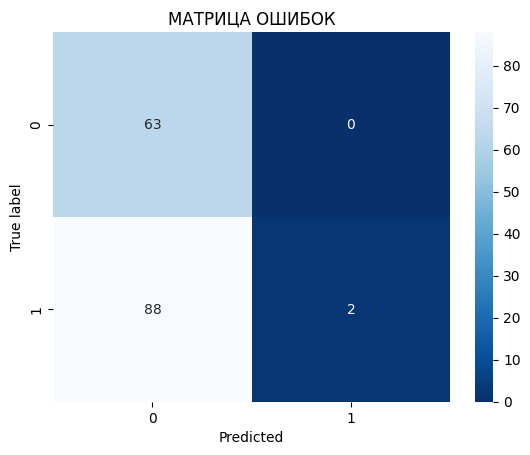

In [143]:
cm = confusion_matrix(y_test, data['y_pred_0.87'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.title('Матрица ошибок'.upper())
plt.ylabel('True label')
plt.xlabel('Predicted'); 

In [144]:
accuracy = accuracy_score(y_test, data['y_pred_0.87'])
recall = recall_score(y_test, data['y_pred_0.87'])
precision = precision_score(y_test, data['y_pred_0.87'])


tn, fp, fn, tp = confusion_matrix(y_test, data['y_pred_0.87']).ravel()
specificity = tn / (tn+fp)

print('accuracy: ',round(accuracy ,3))
print('recall: ',round(recall ,3))
print('precision: ',round(precision,3))
print('specificity: ',round(specificity,3))

accuracy:  0.425
recall:  0.022
precision:  1.0
specificity:  1.0


Было принято решение изменить порог принадлежности к классам на значение 0.87. 

При этом точность модели упала до ~43%. 

При таком пороге значение `precision` равно 1, т.е. модель не классифицирует невкусное молоко как вкусное (при этом модель классифицирует вкусное молоко как невкусное в 98% случаев). 

### Прогноз

In [145]:
cow_buy_predict_class = cow_buy_predict[['breed', 'pasture_type', 'age', 'spo_category', 'dad_bull_breed', 'dad_bull_name', 
                                         'EFU_squared', 'fat_content', 'raw_protein', 'protein']].copy()

In [146]:
# кодирование выборки
X_ohe = encoder.transform(cow_buy_predict_class[cat_col_names]) 

# масштабирование выборки
X_scaled = scaler.transform(cow_buy_predict_class[count_col_names]) 

# объединение массивов
X = np.hstack([X_ohe, X_scaled])

y_proba = clf.predict_proba(X)[:,1]
data = pd.DataFrame(zip(y_test, y_proba), columns = ['y_valid', 'y_proba']).sort_values(by='y_proba',ascending=False) 

data.head()

y_valid   y_proba
9         0  0.742421
13        1  0.695477
0         1  0.683848
6         1  0.683848
16        1  0.680221

In [147]:
cow_buy_predict.loc[:, 'milk_taste_predict'] = (clf.predict_proba(X)[:,1] >= 0.87).astype(int) 
cow_buy_predict[cow_buy_predict['milk_taste_predict'] > 0]

Empty DataFrame
Columns: [breed, pasture_type, dad_bull_breed, dad_bull_name, fat_content, protein, age, efu, raw_protein, spo, EFU_squared, spo_category, milk_yield_predict, milk_taste_predict]
Index: []

Если мы выставляем значение порога, равное 0.87, то ни одна корова не попадает в выборку с вкусным молоком. 

Единственный вариант появляется при указании порога 0.74. 

In [148]:
cow_buy_predict.loc[:, 'milk_taste_predict'] = (clf.predict_proba(X)[:,1] >= 0.74).astype(int) 
cow_buy_predict[cow_buy_predict['milk_taste_predict'] > 0]

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
9  РефлешнСоверинг    Холмистое         Айдиал        Буйный          3.4   

   protein          age        efu  raw_protein      spo  EFU_squared  \
9    3.079  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   

   spo_category  milk_yield_predict  milk_taste_predict  
9  выше_границы         6369.053045                   1

In [149]:
# посмотрим на соотношение
cow_buy_predict['milk_taste_predict'].value_counts()

milk_taste_predict
0    19
1     1
Name: count, dtype: int64

In [150]:
# наконец сформируем список коров, которые подходят под заданные критерии
cow_to_buy = cow_buy_predict[(cow_buy_predict['milk_taste_predict']==1) & (cow_buy_predict['milk_yield_predict'] > 6000)]
cow_to_buy

breed pasture_type dad_bull_breed dad_bull_name  fat_content  \
9  РефлешнСоверинг    Холмистое         Айдиал        Буйный          3.4   

   protein          age        efu  raw_protein      spo  EFU_squared  \
9    3.079  менее_2_лет  15.271152  2018.417402  0.95888   233.208082   

   spo_category  milk_yield_predict  milk_taste_predict  
9  выше_границы         6369.053045                   1

## Итоговые выводы

1. На этапе предобработки данных было выполнено следующее:
- переименование столбцов во всех таблицах;
- проверка на наличие пропусков - пропуски отсутствуют;
- проверка на наличие дубликатов - явные дубликаты удалены/скрытые скорректированы.

2. На этапе исследовательского анализа было выполнено следующее:
2.1. Проанализированы данные о стаде фермера, скорректированы данные для исключения аномалий в данных.
2.2. Проанализированы данные о стаде от "ЭкоФермы", корректировка данных не требовалась. 
Выявлена необходимость масштабирования и кодирования данных. 

3. На этапе корреляционного анализа было выполнено следующее:
- сформирован перечень признаков, с которыми выявлена корреляция признака `Удой` - ЭКЕ (`energy_feed_unit`), СПО (`sugar_protein_ratio`), Жирность (`fat_content`).
- выявлена нелинейная зависимость между параметрами:
	- `Удой` и ЭКЕ (для использования данных параметр ЭКЕ был возведен в квадрат);
	- `Удой` и СПО (для использования данных параметр СПО был преобразован в категориальный).
- выявлена линейная зависимость с параметром Сырой протеин;
- было принято решение не использовать параметры Жирность и Вкус молока в качестве входных для обучения модели для расчета Удоя. 

4. На этапе обучения моделей линейной регрессии были получены следующие результаты: 
4.1. Первая модель:
- значения параметра ЭКЕ использовались до их обработки, а параметр СПО не использовался для обучения;
- показатель R² составил ~75%;
- анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания не похоже на линейное). 

4.2. Вторая модель:
- был использован параметр ЭКЕ в квадрате, параметр СПО был преобразован в категориальный и использовался для обучения модели;
- показатель R² составил ~83%;
- анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания похоже на линейное).

4.3. Третья модель:
- был использован параметр ЭКЕ в квадрате, параметр СПО был преобразован в категориальный и использовался для обучения модели, для обучения данных в качестве признака был добавлен категориальный признак - Имя папы-быка;
- показатель R² составил ~85%;
- анализ остатков показал, что сумма остатков прогнозной модели близка к нулю (остатки нормально распределены, присутствуют выбросы; распределение на диаграмме рассеивания похоже на линейное).

По результатам сравнения моделей был сделан вывод: лучшие показатели R², MAE, RMSE, MSE у модели № 3. 
Были получены результаты прогнозирования удоя молока с помощью модели №3.  
Все спрогнозированные значения варьируются от минимального 6093 кг до максимального 6593,8 кг, что полностью удовлетворяет запрос фермера (более 6000 кг молока в год).

5. На этапе обучения модели логистической регрессии были получены следующие результаты:
- после первичного анализа веса признаков было принято решение отказаться от использования признаков Сырой протеин, Белок, Порода папы-быка, Имя папы-быка;
- точность модели (`accuracy`) составила 63%;
- стояла задача поднять метрику `precision` до 1, это удалось при выставлении порогового значения равного 0.87;
- при выставлении порога точность модели упала до 42.5%. 

6. По результатам отбора коров по двум критериям сделаны выводы:
- для всех коров, представленных "ЭкоФермой", прогнозируемый Удой составляет выше 6000;
- для 19 коров из 20, представленных "ЭкоФермой", прогнозируемый Вкус молока не соответствует запросу фермера. 
Отобранные коровы размещаются в датафрейме `cow_to_buy`. 
Всего отобрана 1 корова. 
Рекомендуется проанализировать иные признаки, которые могут влиять на Удой и Вкус молока, чтобы улучшить качество моделей. 

Выводы о моделях линейной регрессии и логистической регрессии.
1. Какие способы улучшения качества регрессионной модели вы использовали в этой задаче?

Для улучшения качества необходимо было добиться линейной зависимости между входными и целевым признаком.
На улучшение качества повлияло добавление нового признака. 

2. Возможно ли ещё улучшить результаты регрессионной модели? Если можно, то как? Если нет, то почему?

Стоит найти и проанализировать иные признаки, которые могут влиять на целевой признак. 
Стоит расширить выборку данных. 

3. Какие метрики моделей классификации, в том числе логистической регрессии, важны при анализе рисков или экономических расчётов?

В моделях классификации важно учитывать метрики:
- accuracy - точность модели;
- recall - показывает как часть модель ошибается при предсказании и предсказывает 0 вместо 1;
- precision - показывает корректно ли модель предсказывает значения 1. 